In [120]:
import retinanalysis as ra
import retinanalysis.schema as schema
import retinanalysis.dedup as dd
import importlib
importlib.reload(dd)
import numpy as np
import matplotlib.pyplot as plt

### First, let's pull out a dataframe showing noise runs from a specific experiment day. 
### We can choose this day by querying for specific protocols with specific parameters. 

In [6]:
df = ra.get_datasets_from_protocol_names('.SpatialNoise')
df_1 = df[df['exp_name'] == '20250429C']
display(df_1)


Found 2 protocols matching ".spatialnoise":
['manookinlab.protocols.SpatialNoise'
 'manookinlab.protocols.SpatialNoiseAndMotion']

Found 45 experiments, 201 epoch blocks.



exp_name datafile_name  NDF chunk_name  \
172  20250429C       data001  0.5     chunk1   
173  20250429C       data002  0.5     chunk1   
174  20250429C       data010  0.5     chunk2   
175  20250429C       data011  0.5     chunk2   
176  20250429C       data015  1.0    noise30   

                          protocol_name  is_mea           data_dir  \
172  manookinlab.protocols.SpatialNoise       1  20250429C/data001   
173  manookinlab.protocols.SpatialNoise       1  20250429C/data002   
174  manookinlab.protocols.SpatialNoise       1  20250429C/data010   
175  manookinlab.protocols.SpatialNoise       1  20250429C/data011   
176  manookinlab.protocols.SpatialNoise       1  20250429C/data015   

             group_label  experiment_id  protocol_id  group_id  block_id  \
172                noise            123           26      2265      3347   
173                noise            123           26      2265      3348   
174                noise            123           26      2271      3356   
175                noise            123           26      2271      3357   
176  30 R* spatial noise            123           26      2275      3361   

     chunk_id  
172       477  
173       477  
174       478  
175       478  
176       480

### Let's look at the first datafile from the first chunk.

In [7]:
sb = ra.StimBlock(df_1.at[172, 'exp_name'], df_1.at[172, 'datafile_name'])
ac = ra.AnalysisChunk(df_1.at[172, 'exp_name'], df_1.at[172, 'chunk_name'])

Nearest noise chunk for data001 is chunk1 with distance 0 minutes.

Loading VCD from /Volumes/data/analysis/20250429C/chunk1/kilosort2.5 ...
VCD loaded with 676 cells.
Loaded spatial maps for channels [0, 2] and 676 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.


#### What ei correlation method should we use? We can compare the results before instantiating our deduplication object.

/Users/racheloaks-leaf/anaconda3/envs/analysis/lib/python3.8/site-packages/matplotlib_venn/layout/venn3/pairwise.py:103: UserWarning: Circle A has zero area.
  warnings.warn("Circle A has zero area.")


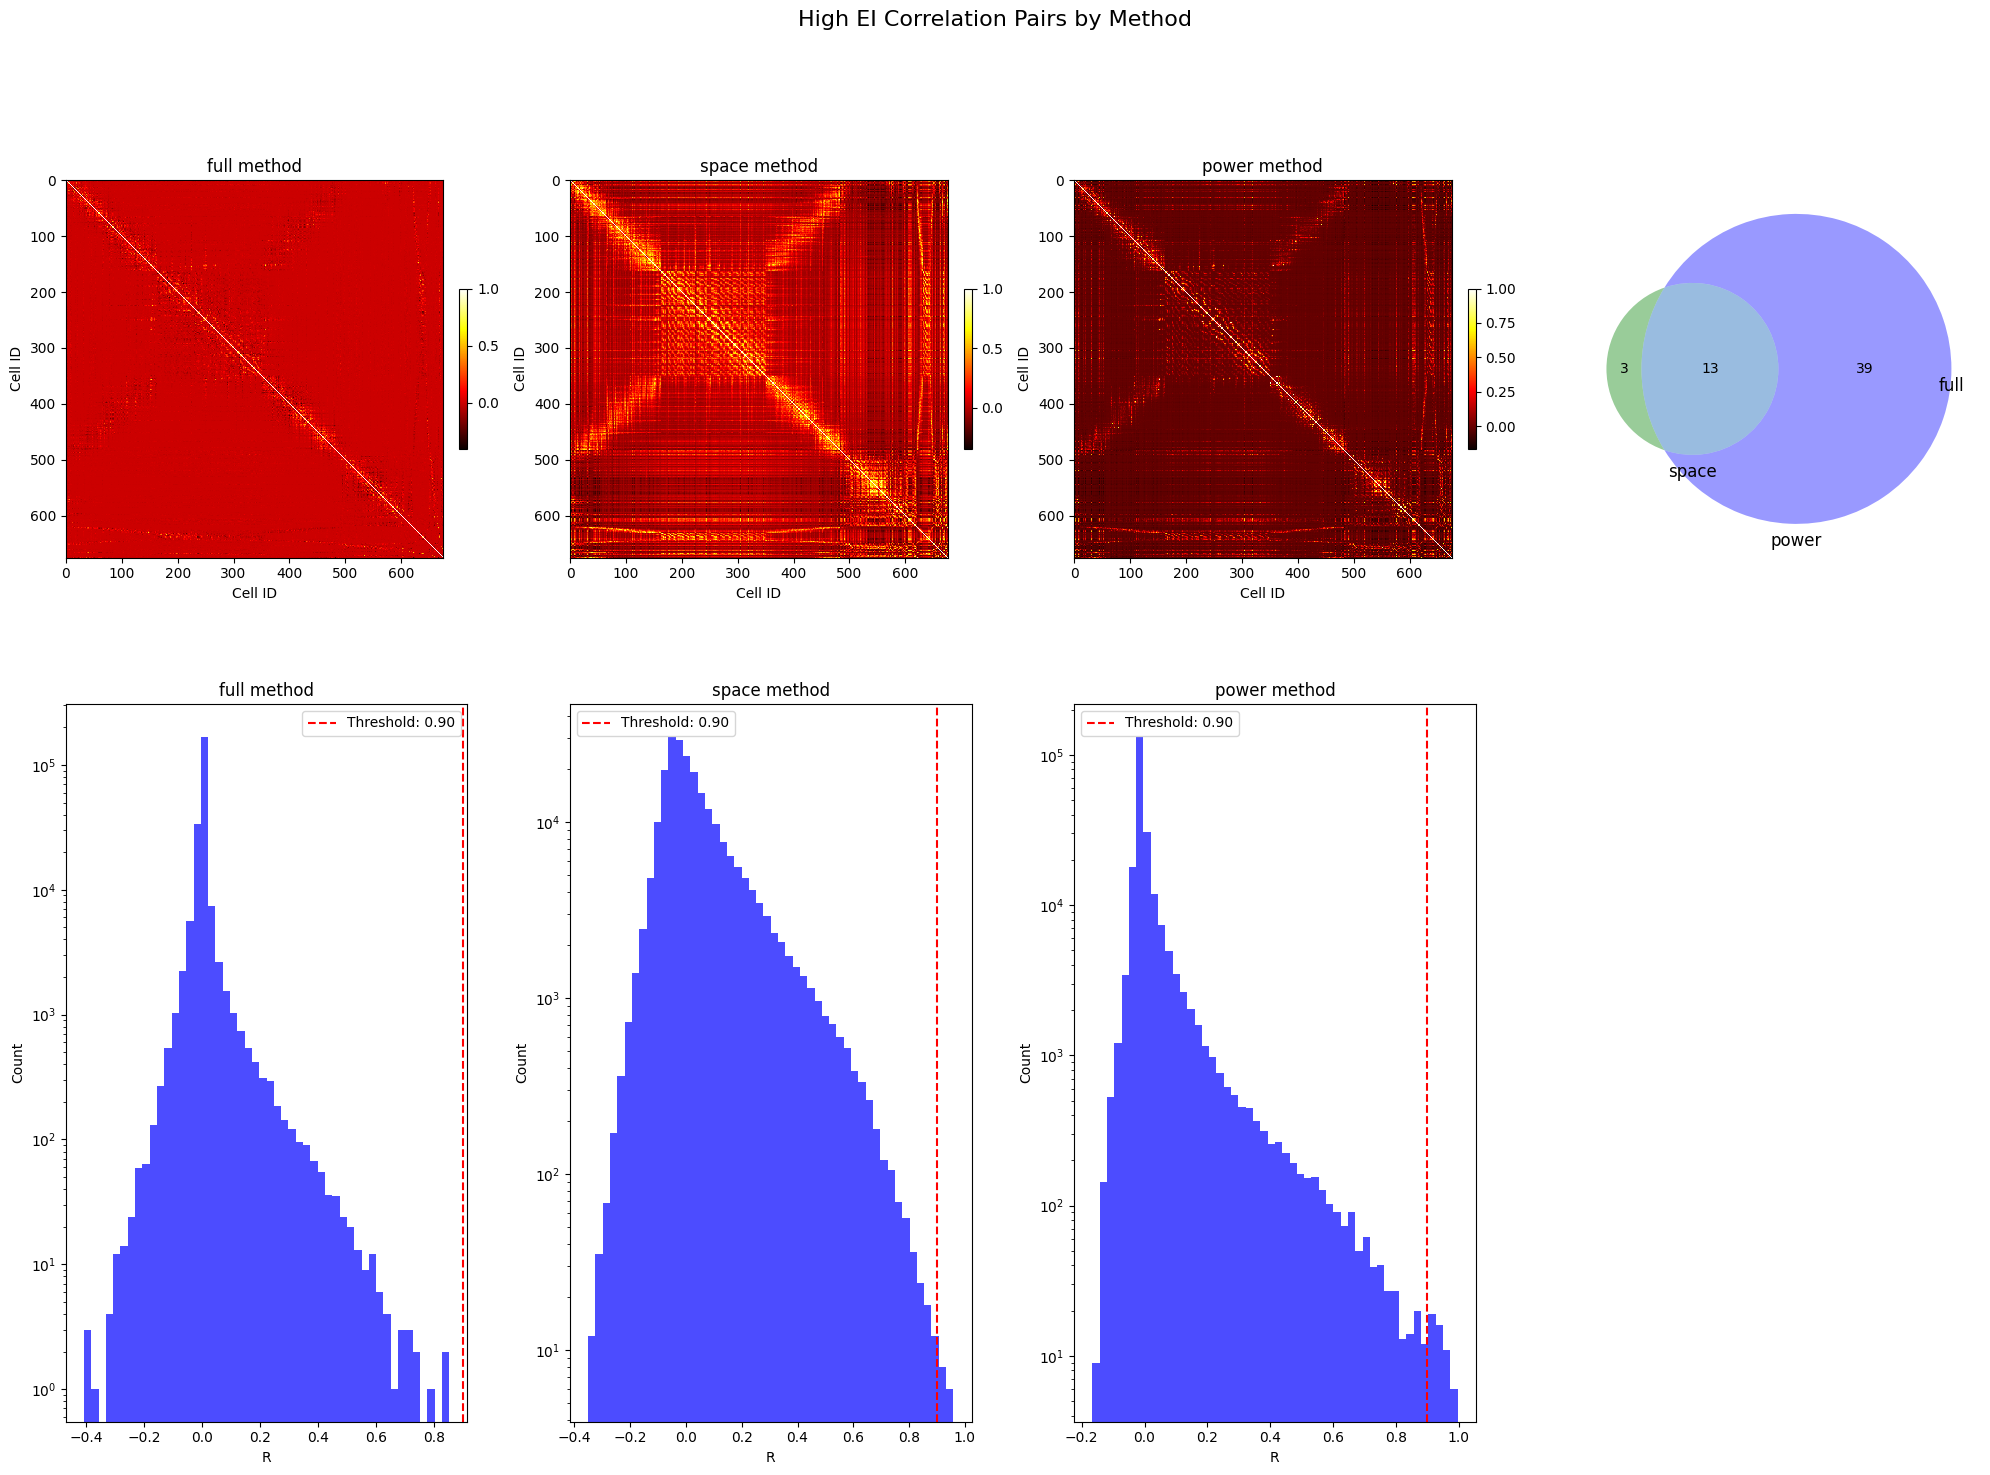

In [11]:
axs, ei_full_pairs, ei_space_pairs, ei_power_pairs = dd.compare_ei_methods(ac, ei_threshold=0.9)

#### Space seems like a middle ground. Let's use that for now.

In [121]:
db = dd.DedupBlock(exp_name=df_1.at[172, 'exp_name'], chunk_name=df_1.at[172, 'chunk_name'], ss_version='kilosort2.5', \
                   pkl_file=None, is_noise=True, ei_method='space', ei_threshold=0.9, sm_threshold=0.9)
db

Loading VCD from /Volumes/data/analysis/20250429C/chunk1/kilosort2.5 ...
VCD loaded with 676 cells.
Loaded spatial maps for channels [0, 2] and 676 cells of shape (127, 203, 2)
Spatial maps have been padded to align with RF parameters.
Creating deduplication sets...
Loading Kilosort amplitudes...


DedupBlock with properties:
  exp_name: 20250429C
  chunk_name: chunk1
  ss_version: kilosort2.5
  noise_status: True
  data_file: None
  cell_ids of length: 676
  ei_threshold: 0.9
  sm_threshold: 0.9
  ei_method: space

### Now we can plot the autocorrelation matrix and histograms. Cluster pairs with correlations above threshold are potentially merger targets.

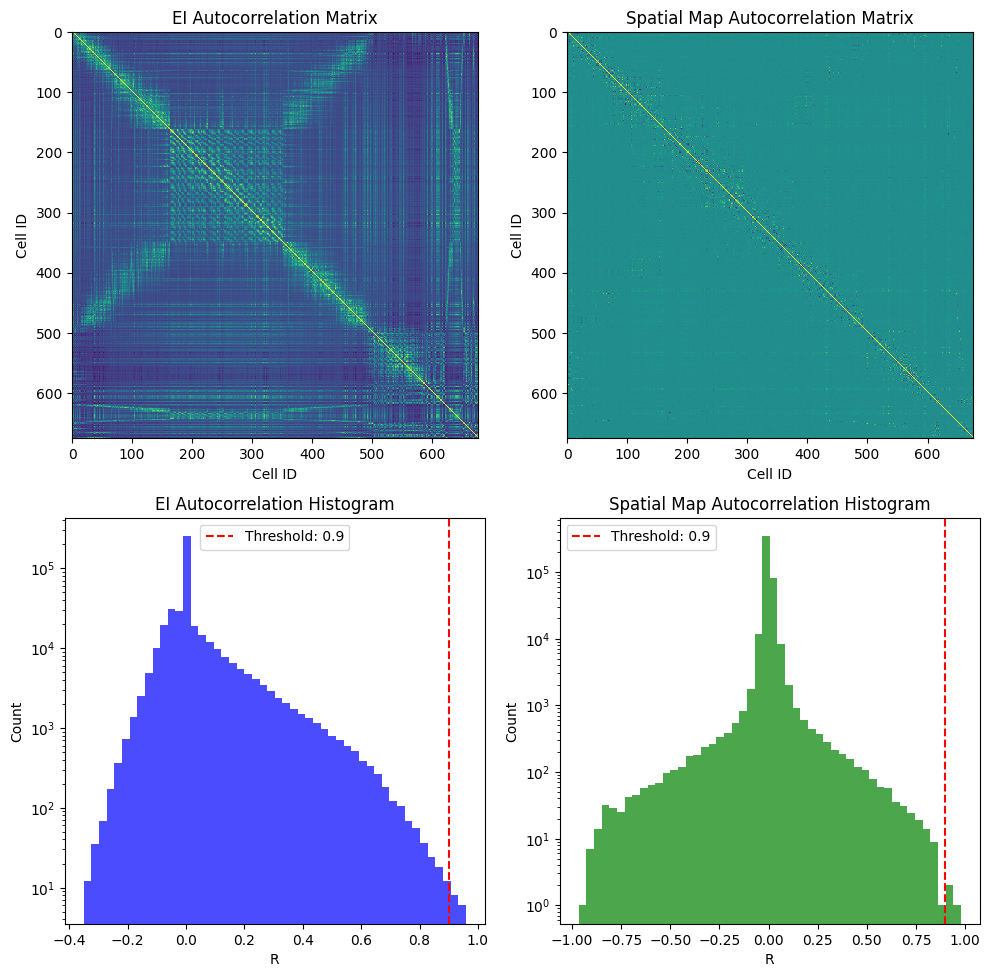

In [60]:
db.plot_correlations(axs=None);

#### We can also plot our cluster RFs, and highlight those with above-threshold correlations with another cluster.

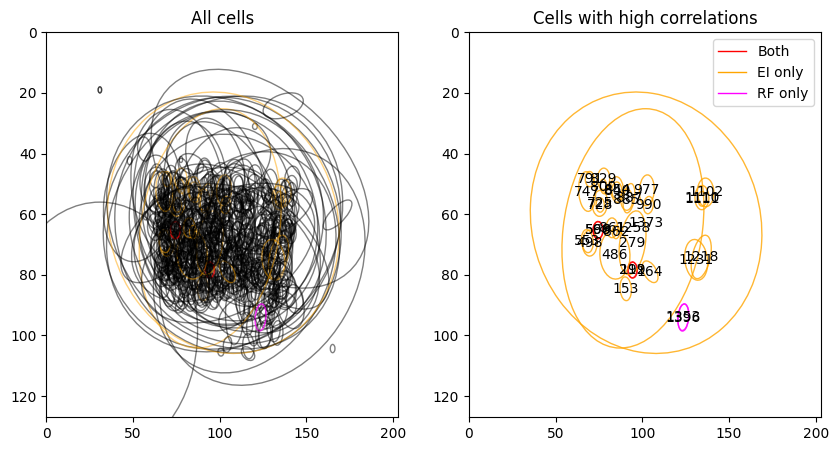

In [85]:
db.plotRFs_dedup(axs=None);

#### We have all sorts of groupings of cells that are highly correlated by ei, spatial map, or both below the hood. We can generate some tables of pairwise statistics for these various groups.

In [90]:
print(db.dedup_sets.keys())

dict_keys(['all_pairs', 'extended_pairs_across', 'all_extended_pairs', 'problem_cells', 'ei_only_cells', 'ei_only_pairs', 'extended_ei_pairs', 'sm_only_cells', 'sm_only_pairs', 'extended_sm_pairs', 'both_cells', 'both_pairs', 'extended_both_pairs'])


In [91]:
summary_stats_all = db.get_summary_stats(pairs=db.dedup_sets['all_pairs'])
summary_stats_all

cluster_a  cluster_b   ei_corr   sm_corr  overlap_fraction
0         153        164  0.952069 -0.006959          0.788023
1         885        887  0.926282  0.244832          0.145157
2         747        791  0.912108 -0.118044          0.112279
3         800        829  0.914783  0.339878          0.009624
4        1258       1373  0.915847 -0.008561          0.286139
5         498        553  0.906033 -0.864103          0.323180
6         725        728  0.952446 -0.856058          0.027612
7         279        486  0.930121 -0.240978          1.000000
8        1102       1110  0.947322 -0.633999          0.077868
9         840        854  0.958703 -0.850062          0.456046
10       1110       1111  0.920551  0.647908          0.006864
11       1218       1231  0.902514  0.694300          0.010963
12        977        990  0.948855  0.302012          0.741890
13        199        212  0.955361  0.919182          0.990300
14        861        862  0.924418  0.395263          0.007176
15        568        596  0.916573  0.918686          0.999702
16       1353       1396  0.572966  0.978599          0.840362

In [94]:
summary_stats_both = db.get_summary_stats(pairs=db.dedup_sets['both_pairs'])
summary_stats_both

cluster_a  cluster_b   ei_corr   sm_corr  overlap_fraction
0        568        596  0.916573  0.918686          0.999702
1        199        212  0.955361  0.919182          0.990300

In [93]:
summary_stats_ei_space = db.get_summary_stats(pairs=db.dedup_sets['ei_only_pairs'])
summary_stats_ei_space

cluster_a  cluster_b   ei_corr   sm_corr  overlap_fraction
0         153        164  0.952069 -0.006959          0.788023
1         885        887  0.926282  0.244832          0.145157
2         747        791  0.912108 -0.118044          0.112279
3         800        829  0.914783  0.339878          0.009624
4        1258       1373  0.915847 -0.008561          0.286139
5         498        553  0.906033 -0.864103          0.323180
6         725        728  0.952446 -0.856058          0.027612
7         279        486  0.930121 -0.240978          1.000000
8        1102       1110  0.947322 -0.633999          0.077868
9         840        854  0.958703 -0.850062          0.456046
10       1110       1111  0.920551  0.647908          0.006864
11       1218       1231  0.902514  0.694300          0.010963
12        977        990  0.948855  0.302012          0.741890
13        861        862  0.924418  0.395263          0.007176

In [95]:
summary_stats_sm = db.get_summary_stats(pairs=db.dedup_sets['sm_only_pairs'])
summary_stats_sm

cluster_a  cluster_b   ei_corr   sm_corr  overlap_fraction
0       1353       1396  0.572966  0.978599          0.840362

####  since overlap is low between high ei and high sm pairs, let's visualize any transitively connected groups across either criterion

/Users/racheloaks-leaf/Desktop/retinanalysis/src/retinanalysis/dedup.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  else:


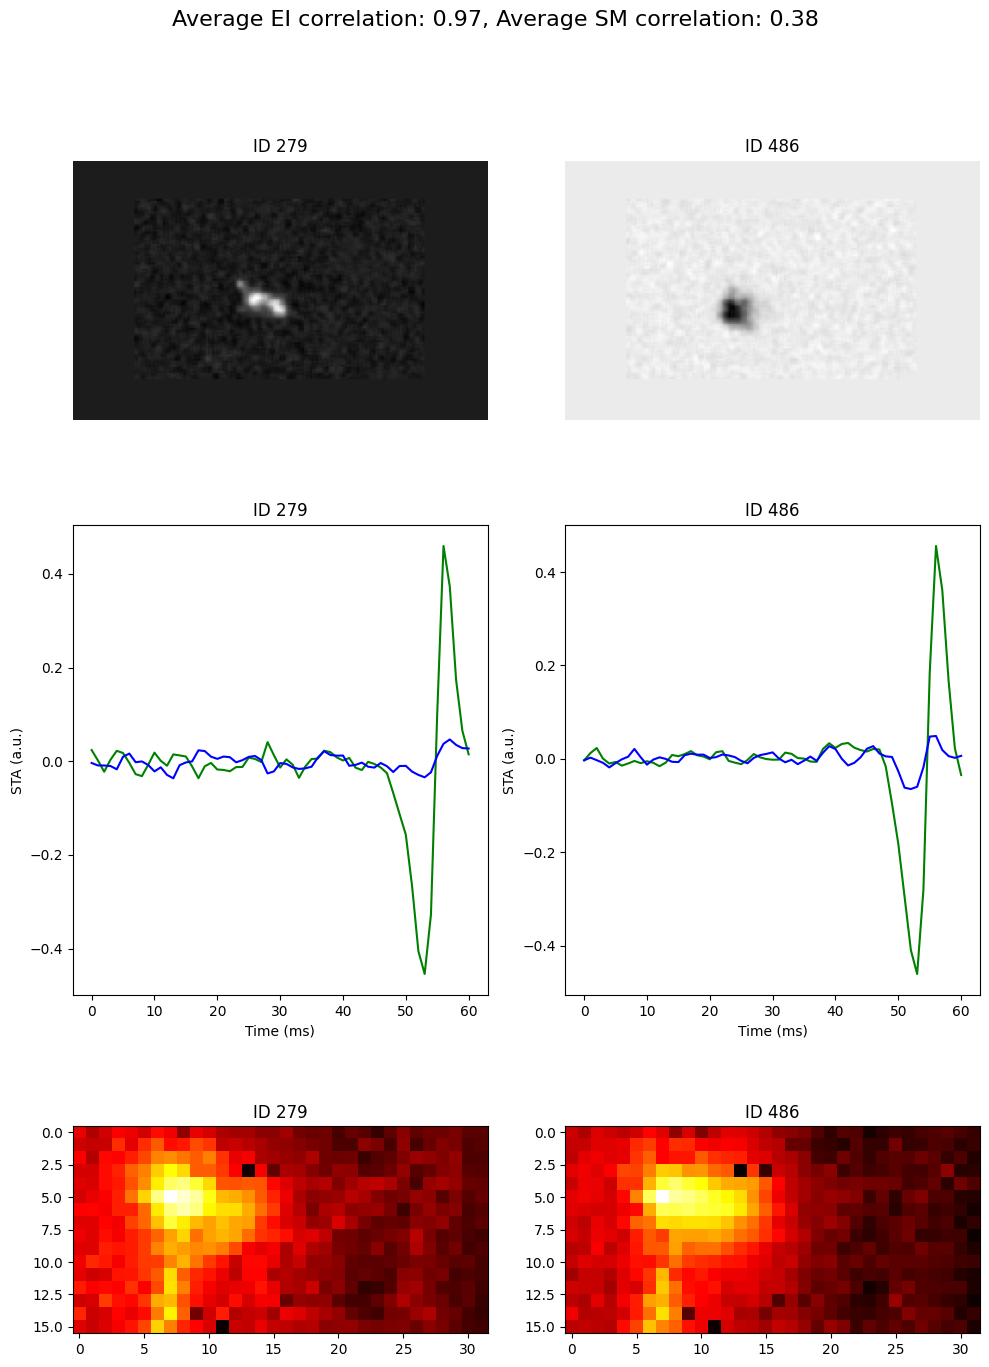

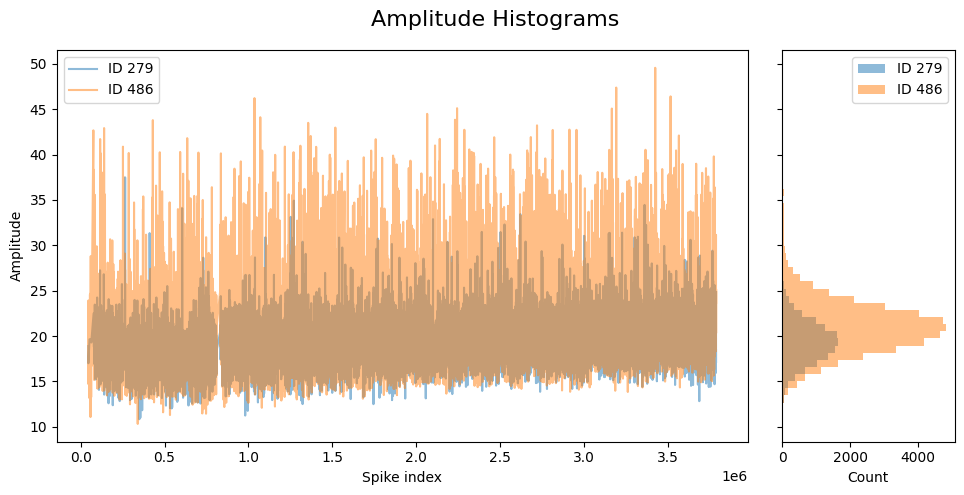

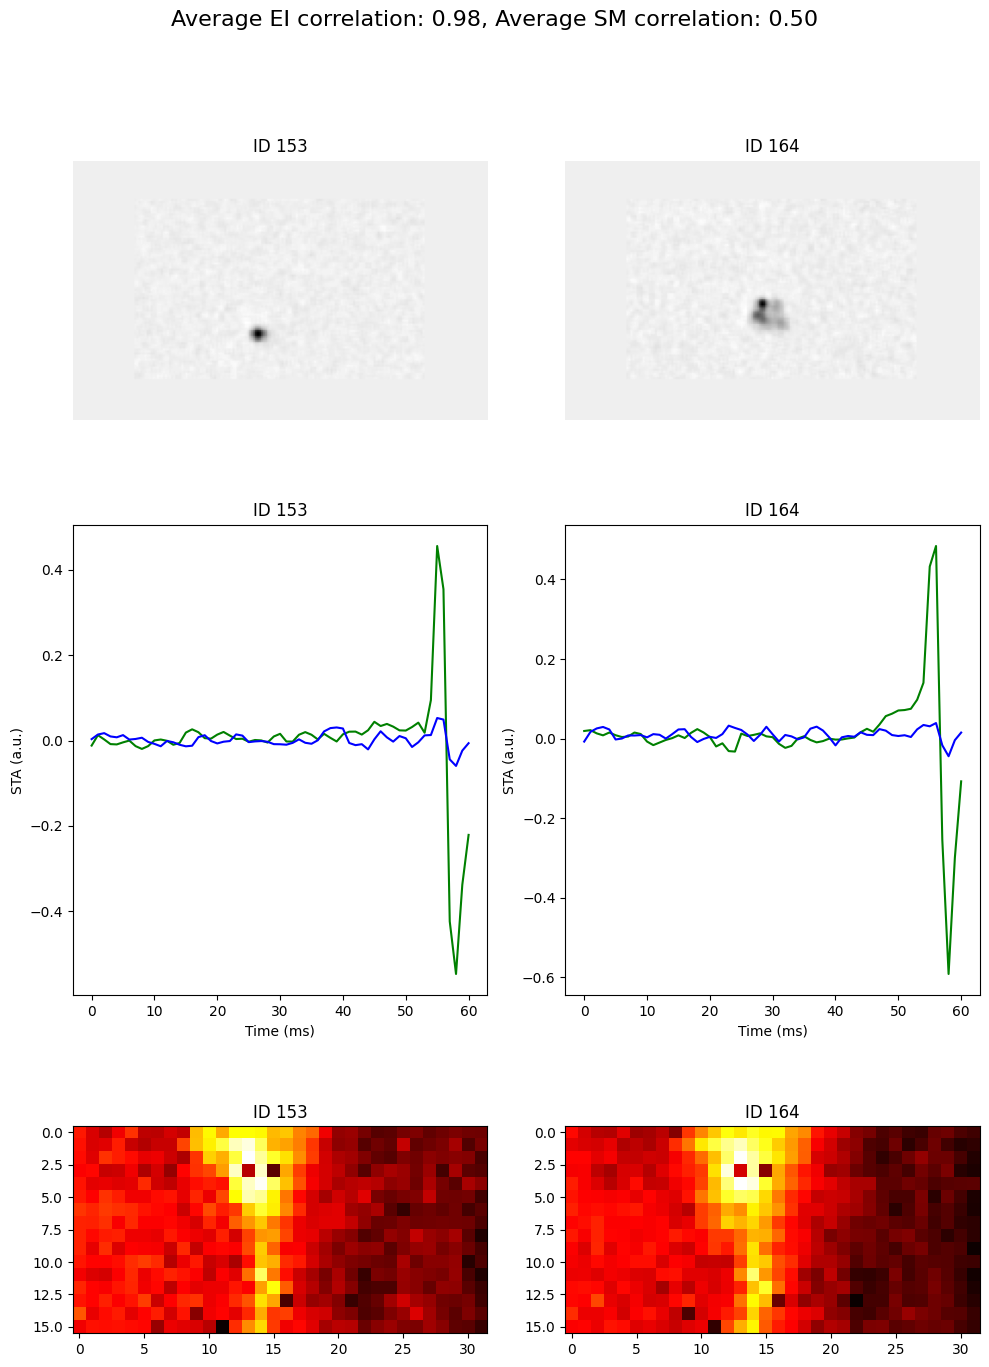

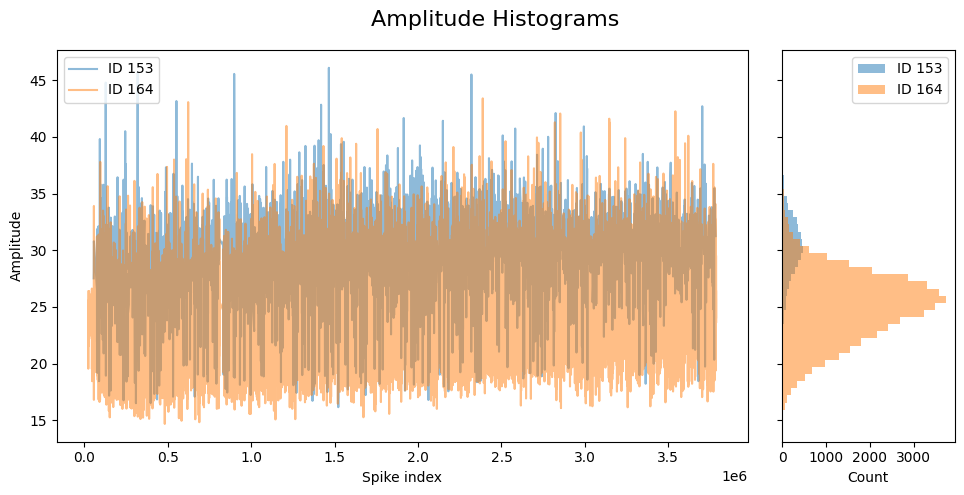

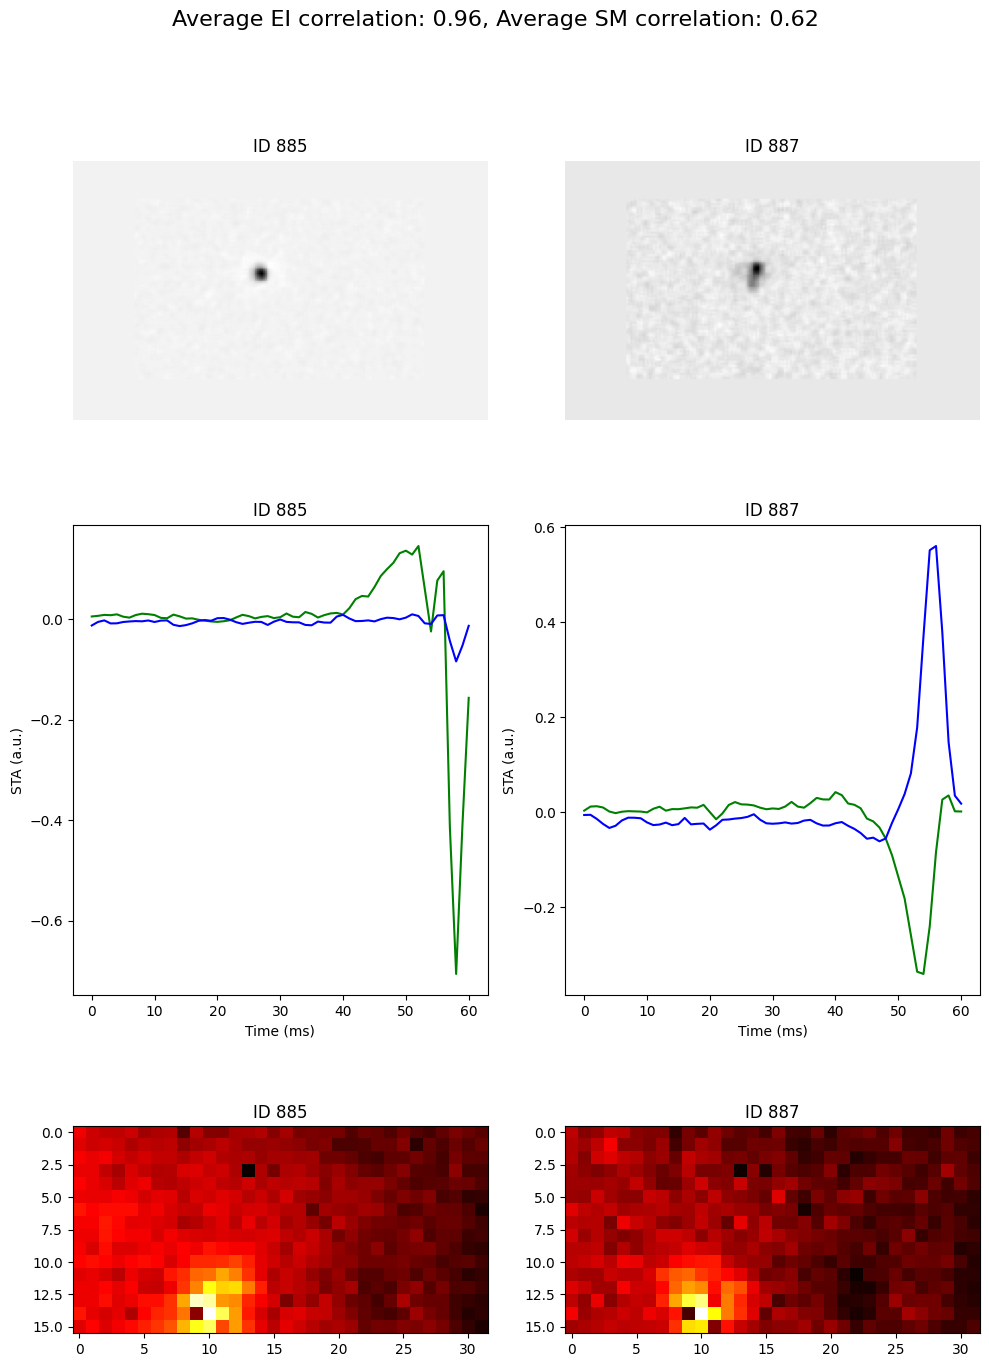

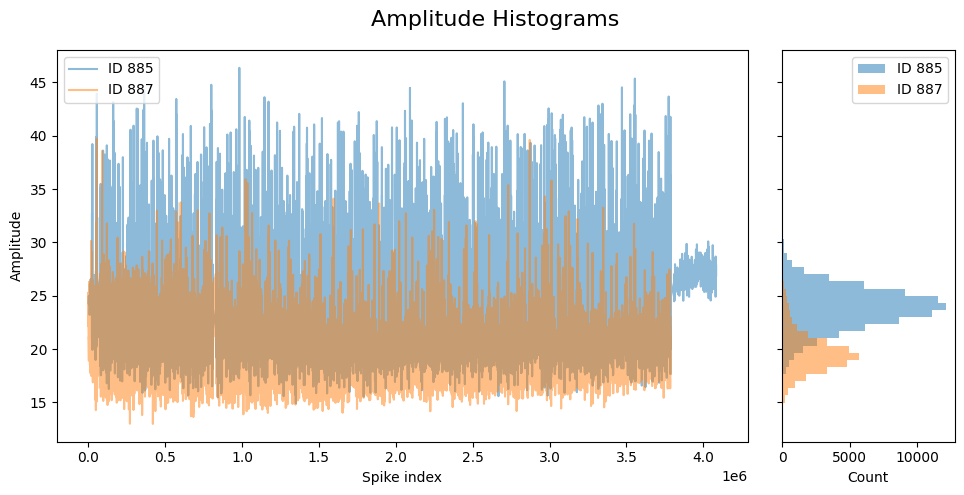

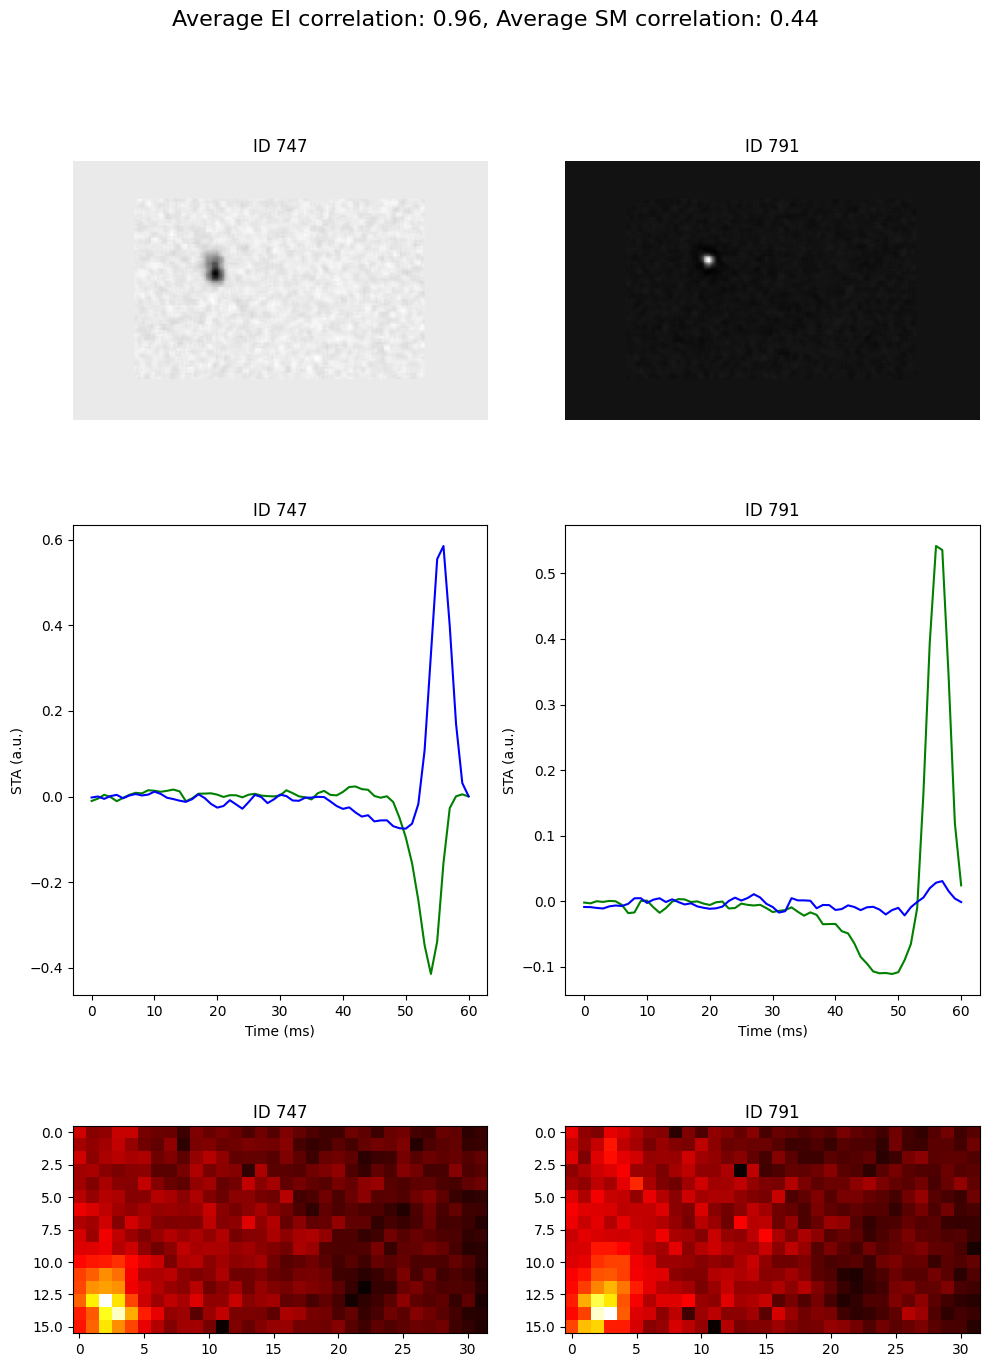

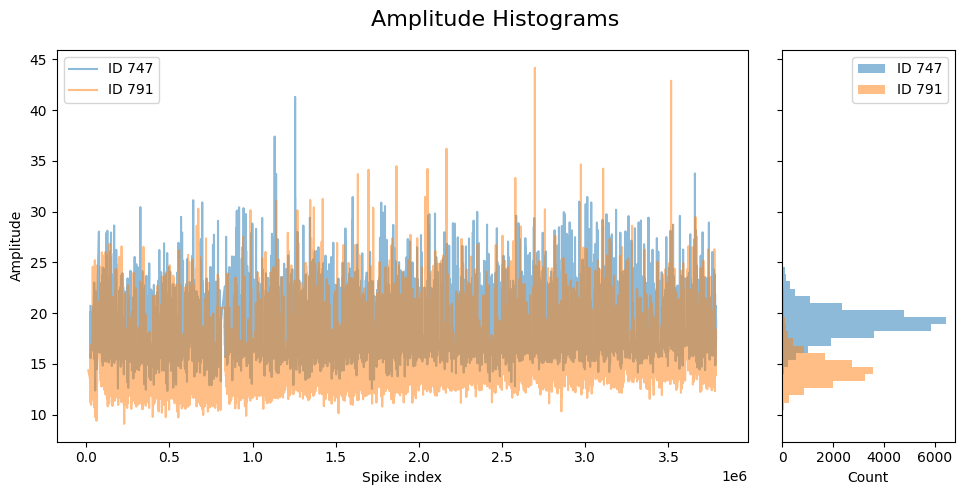

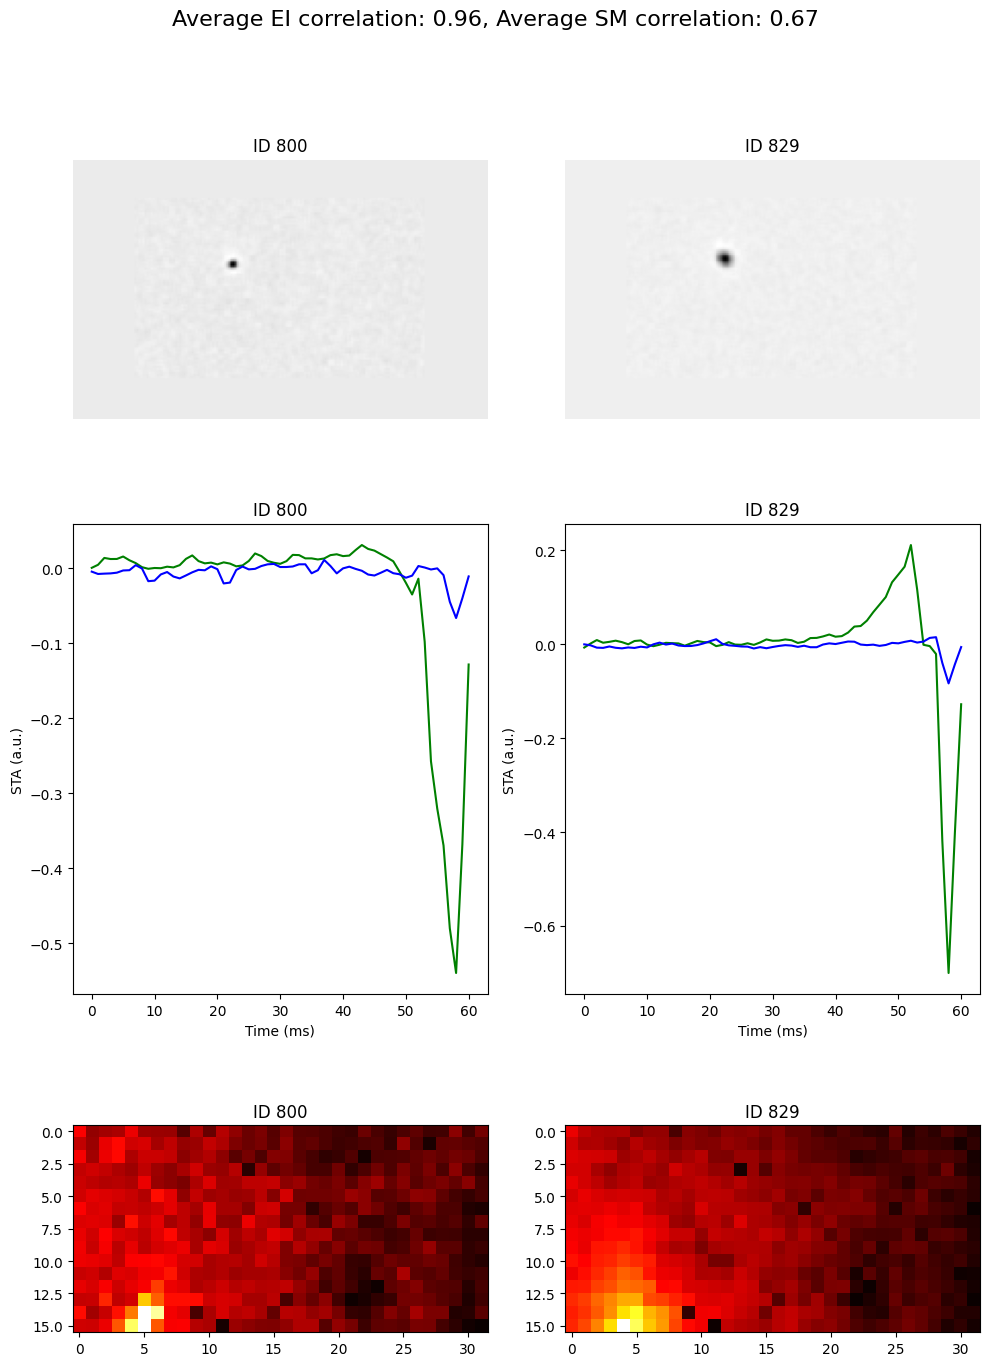

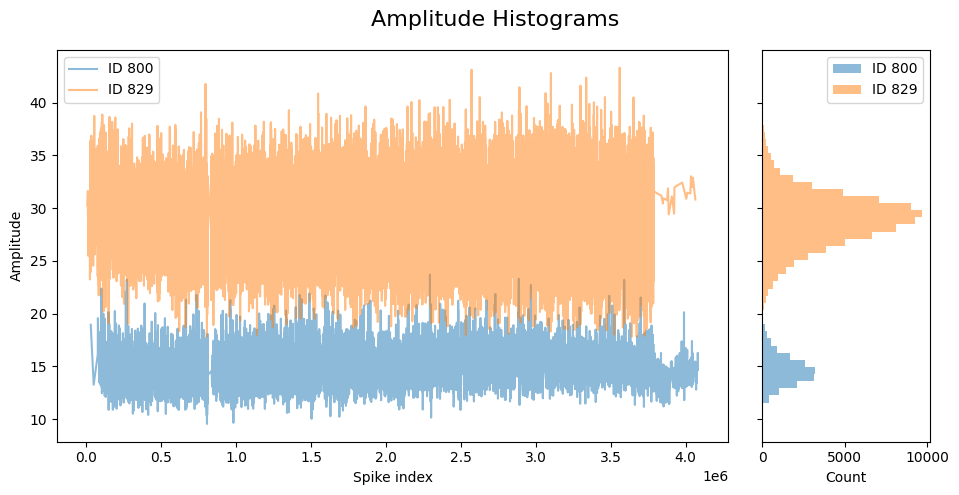

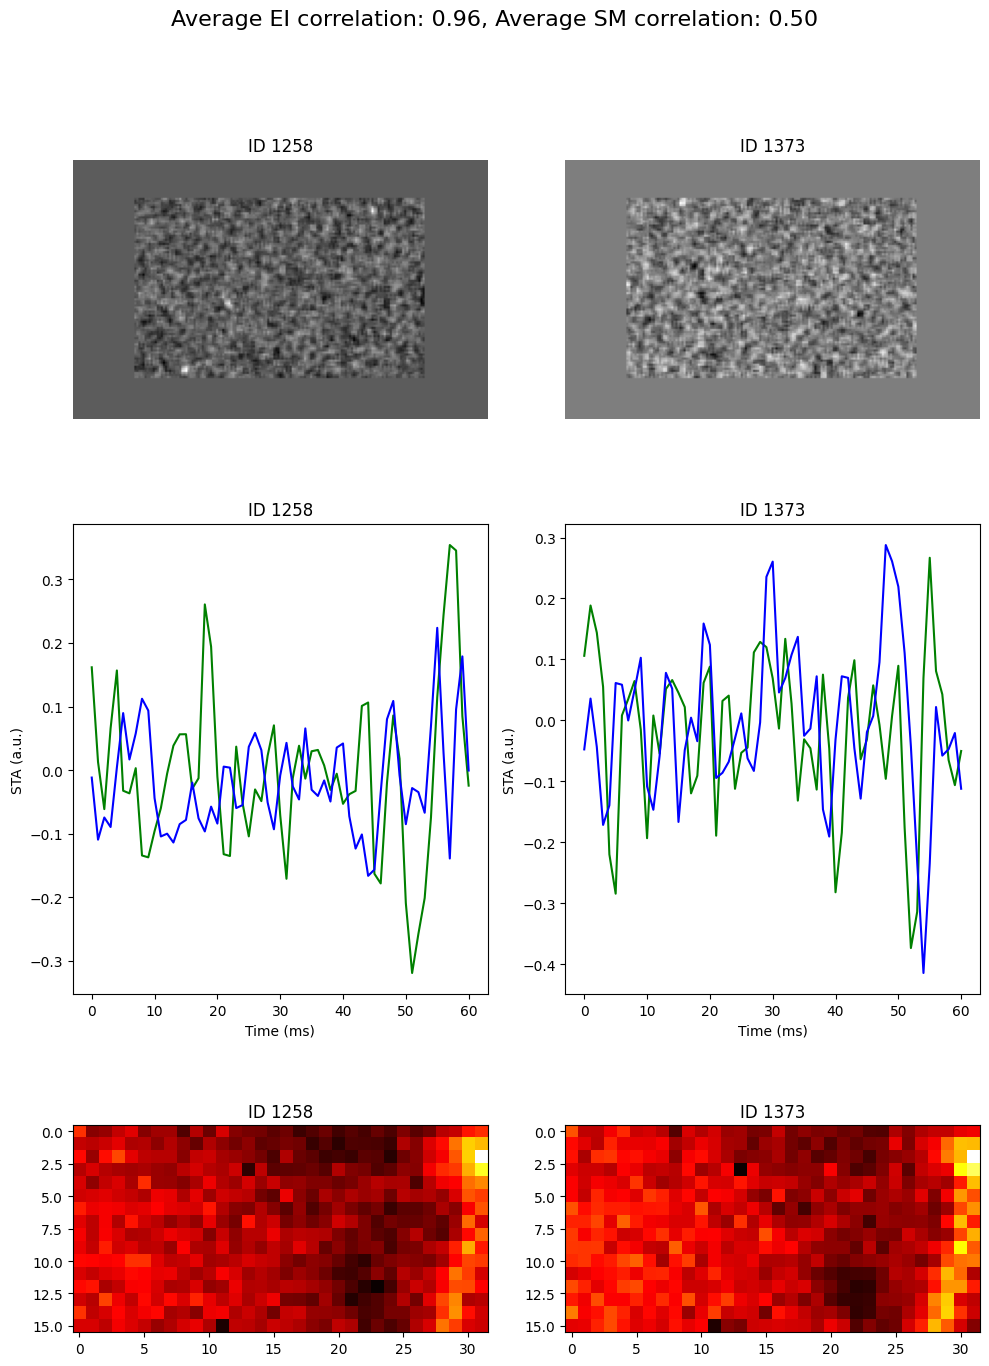

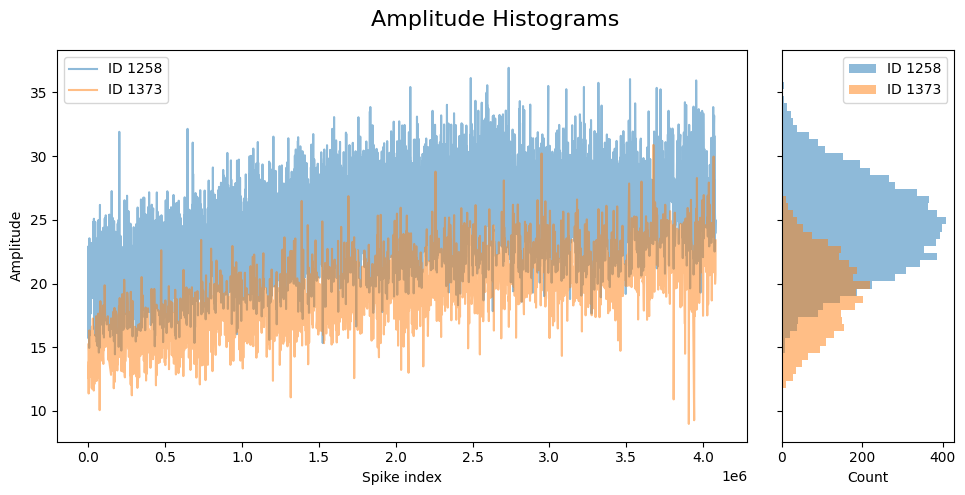

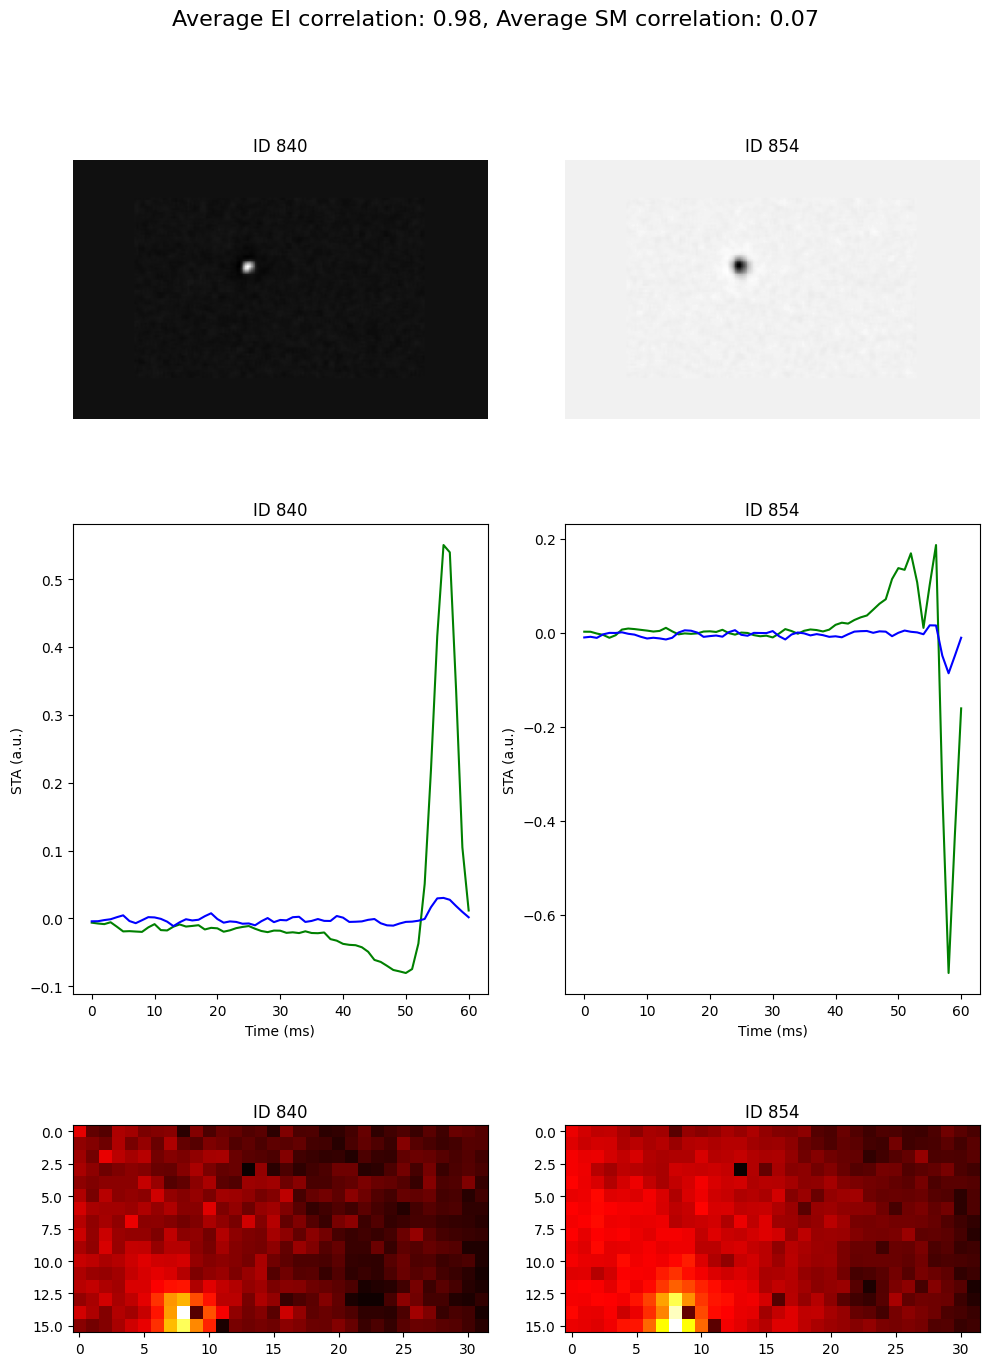

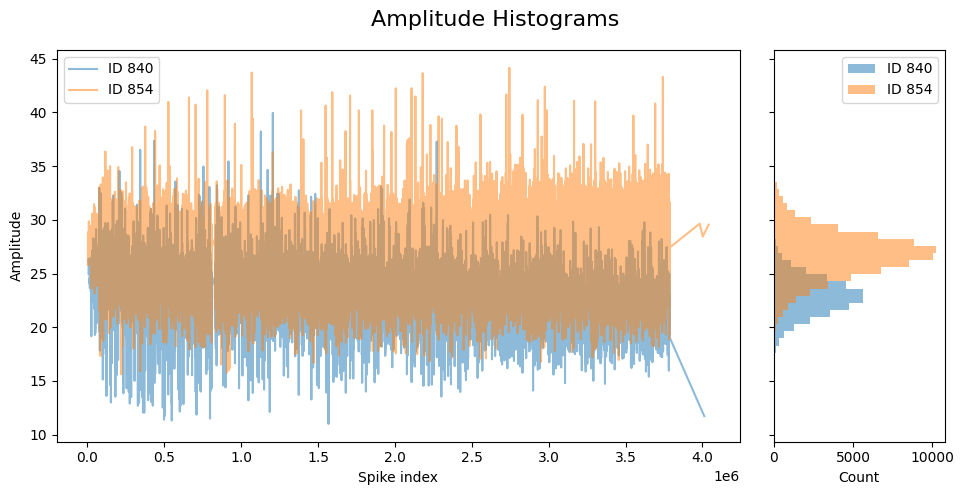

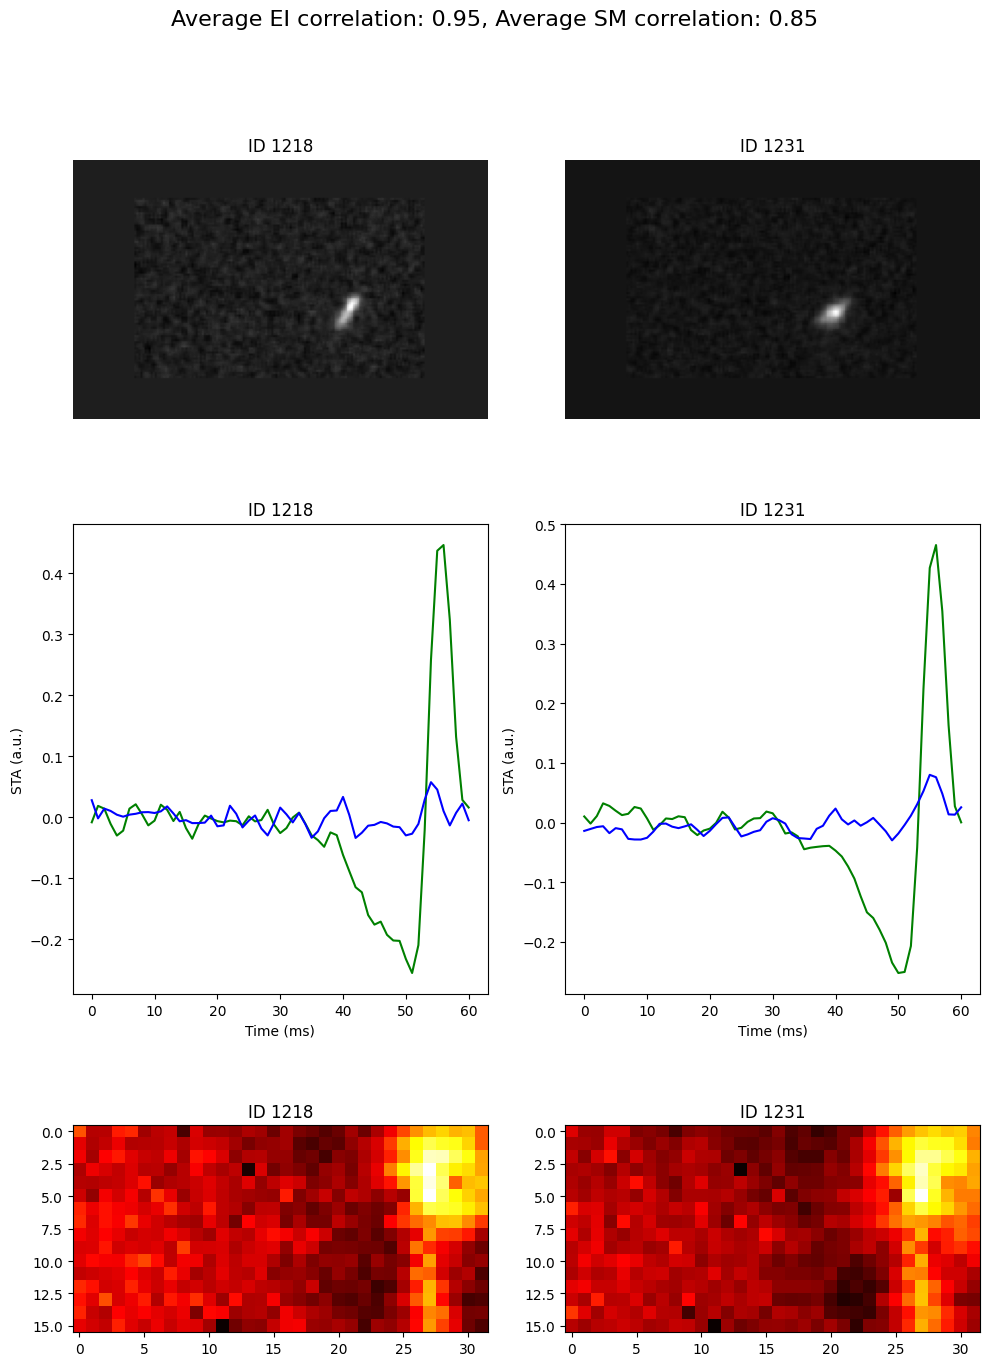

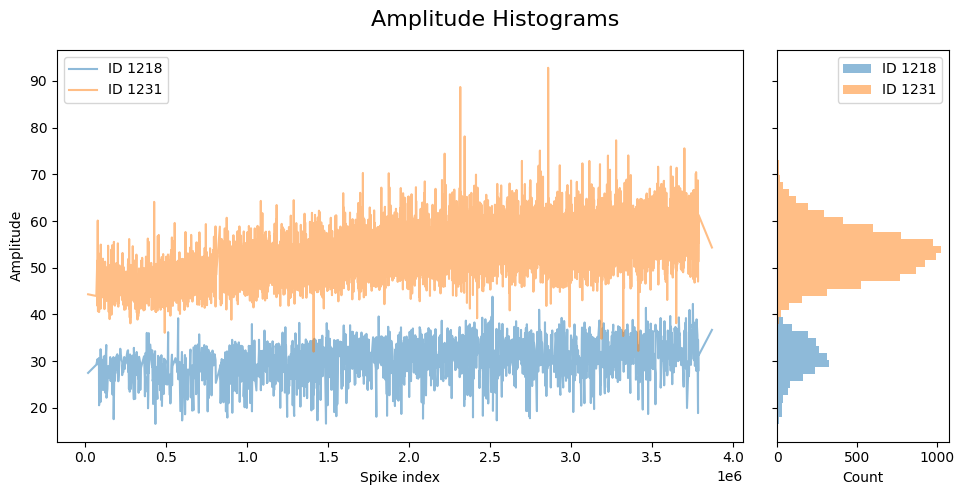

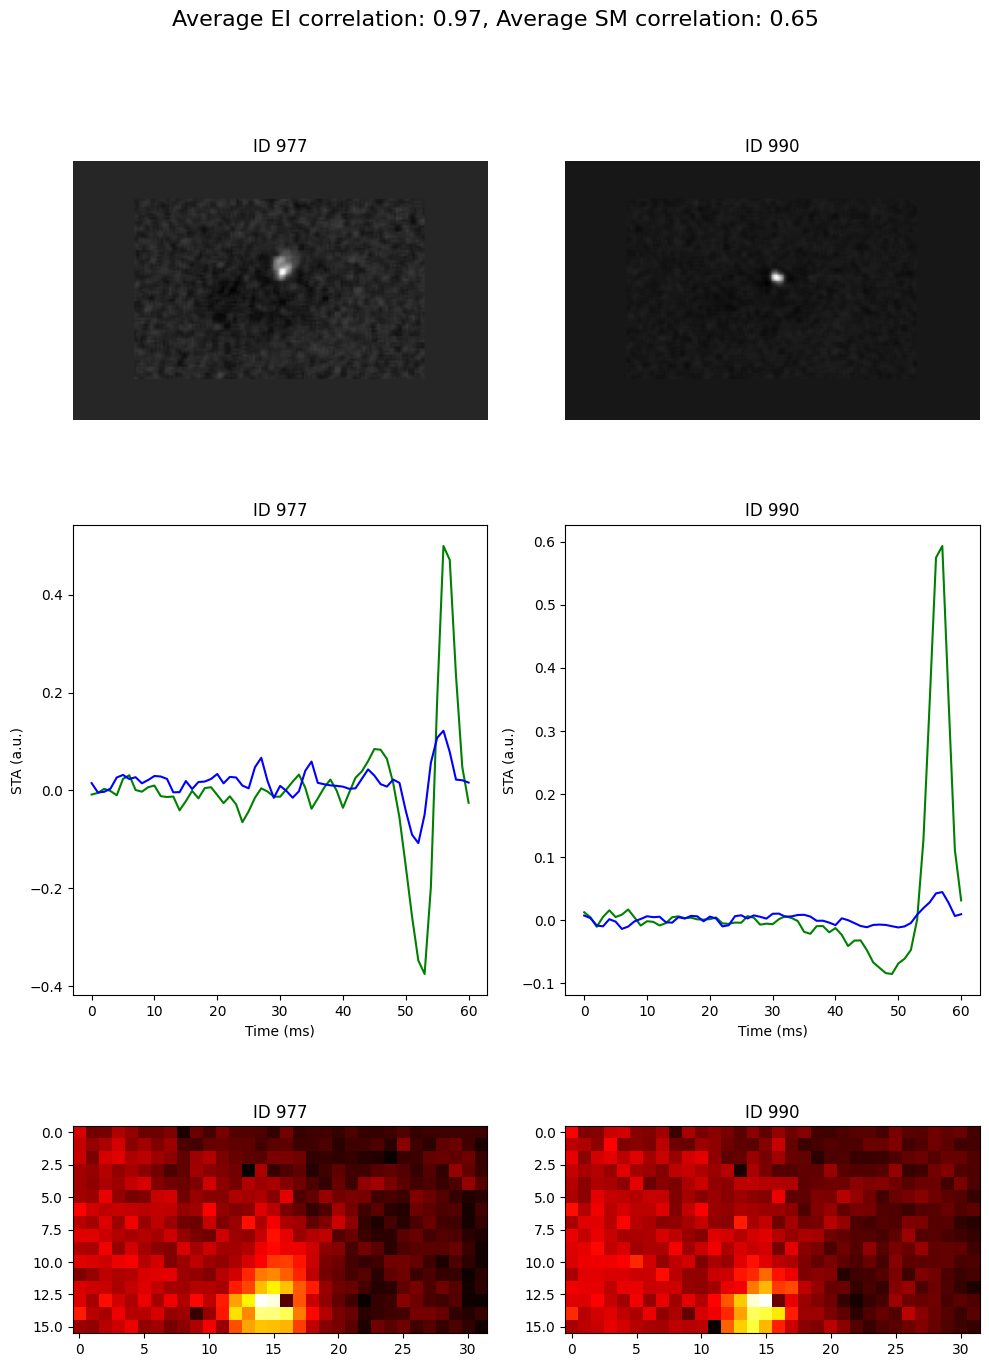

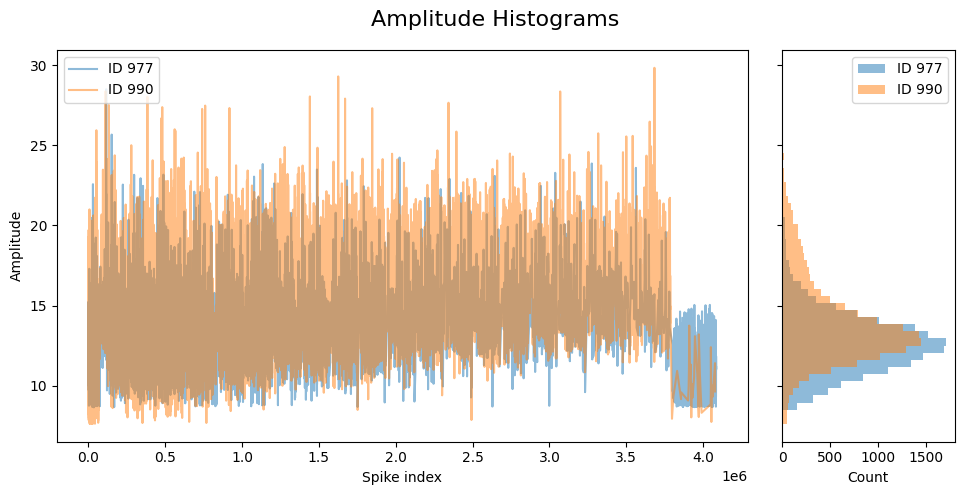

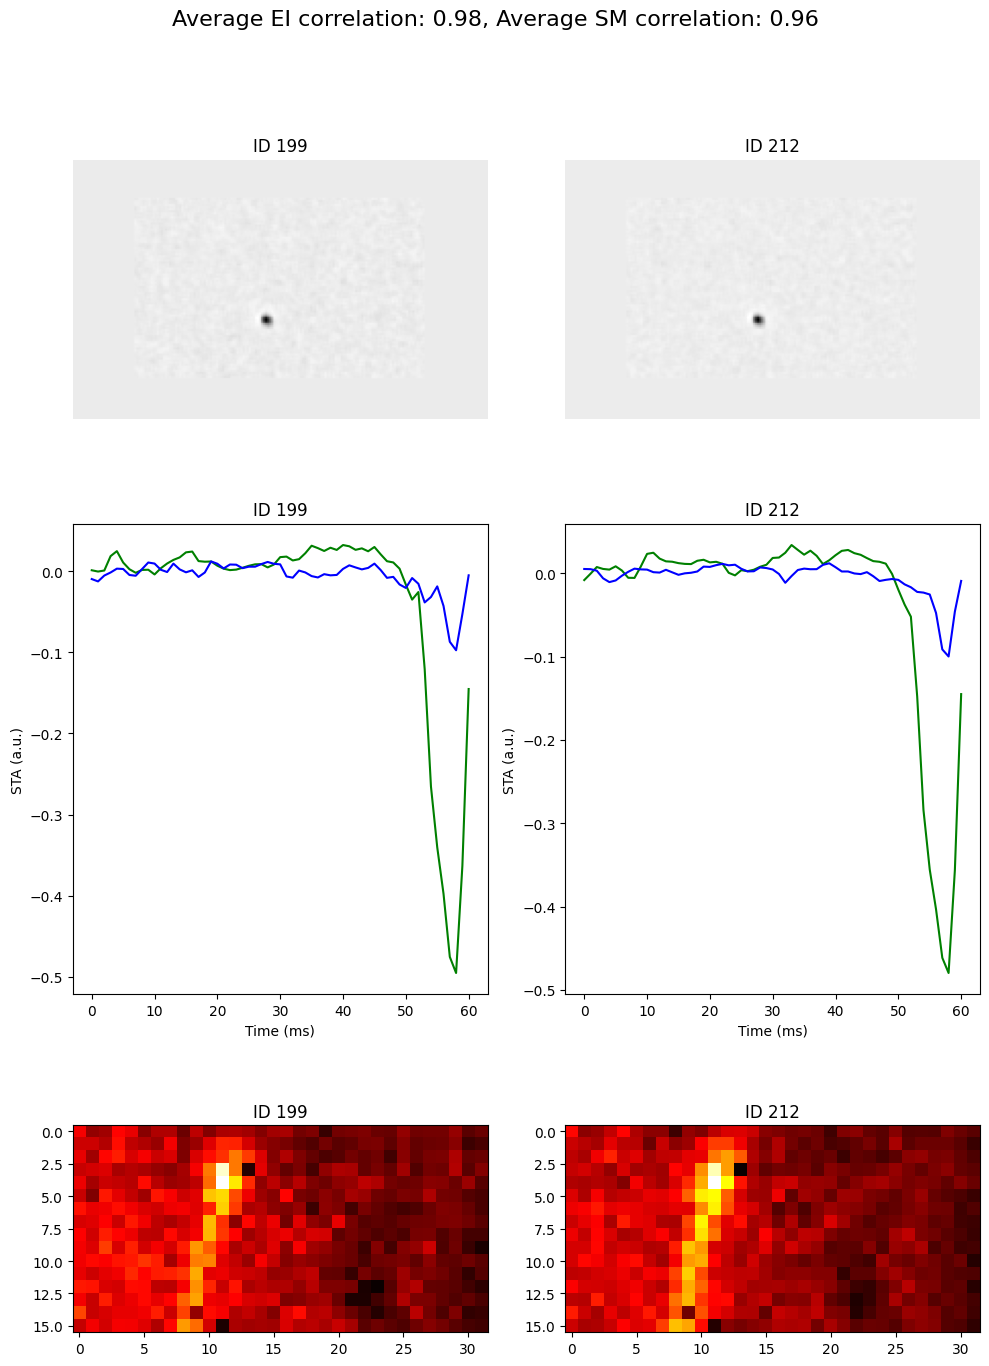

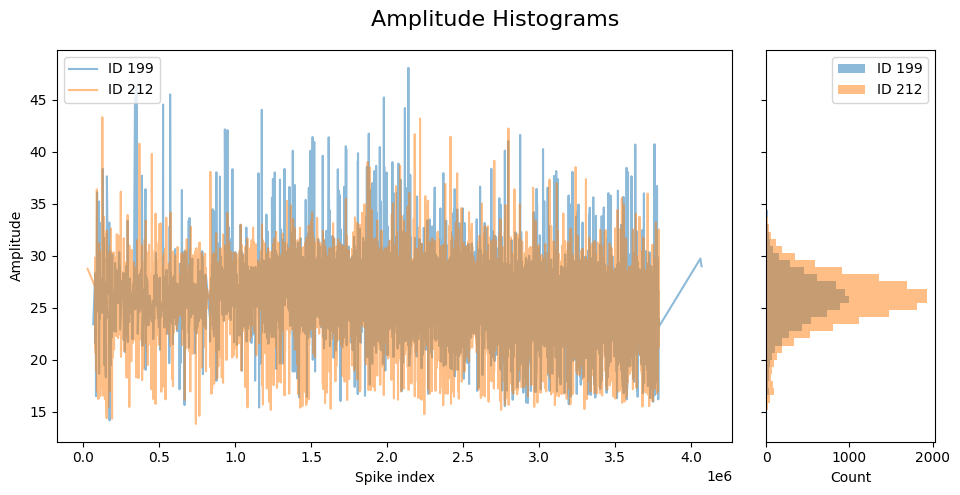

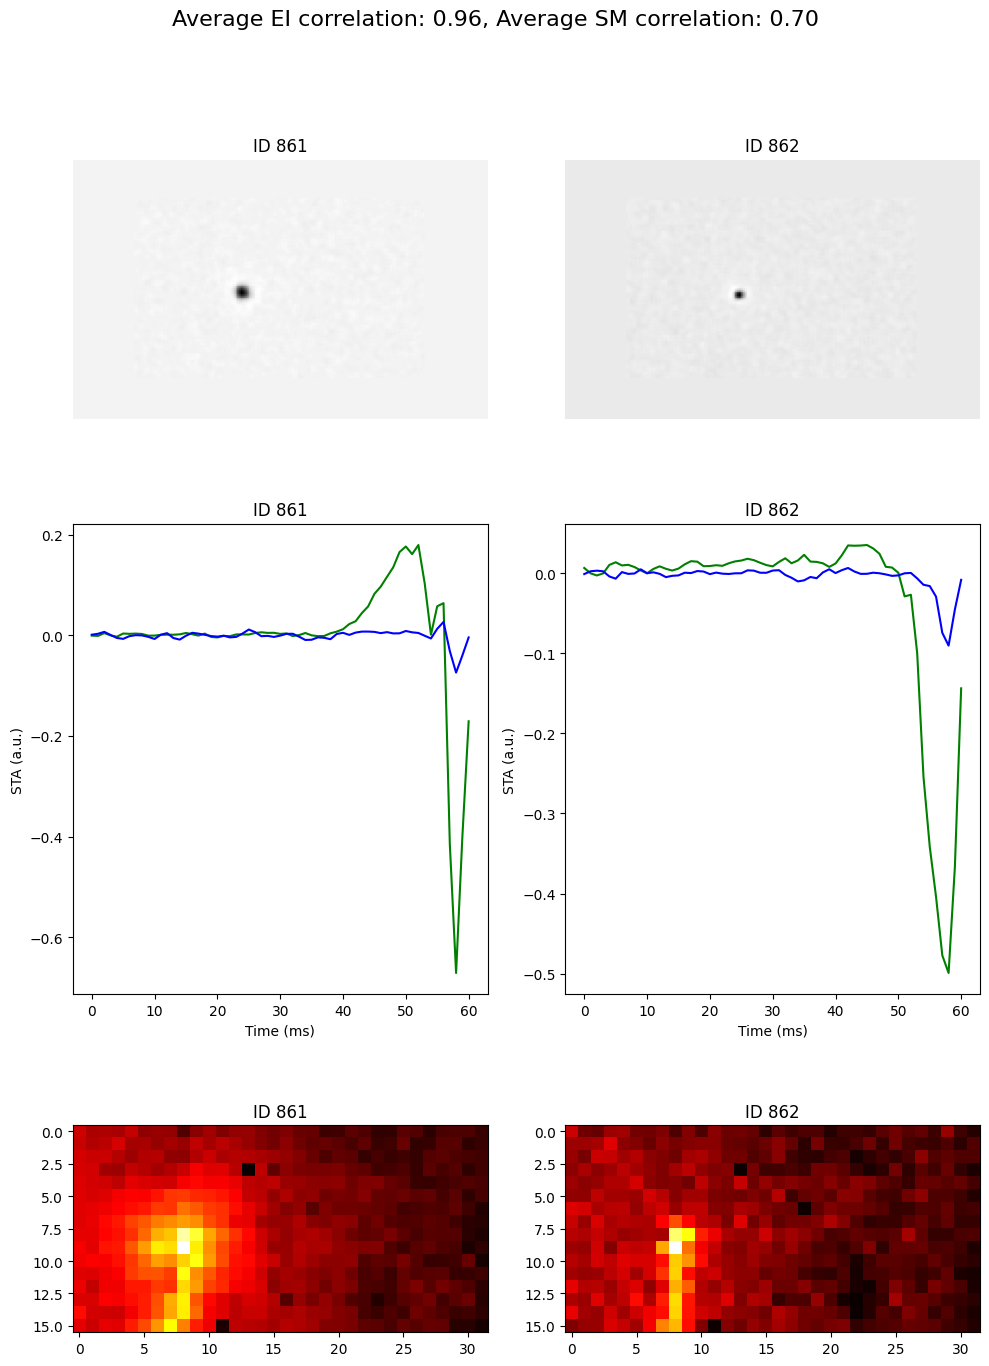

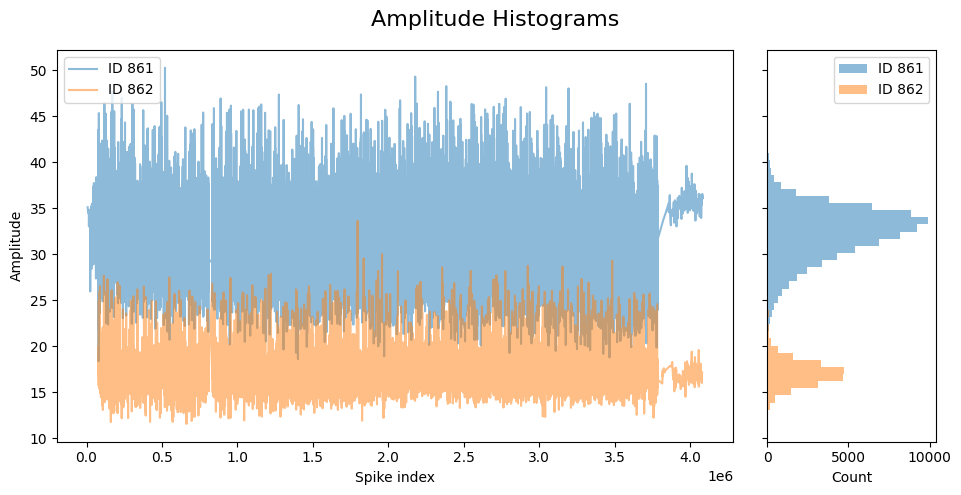

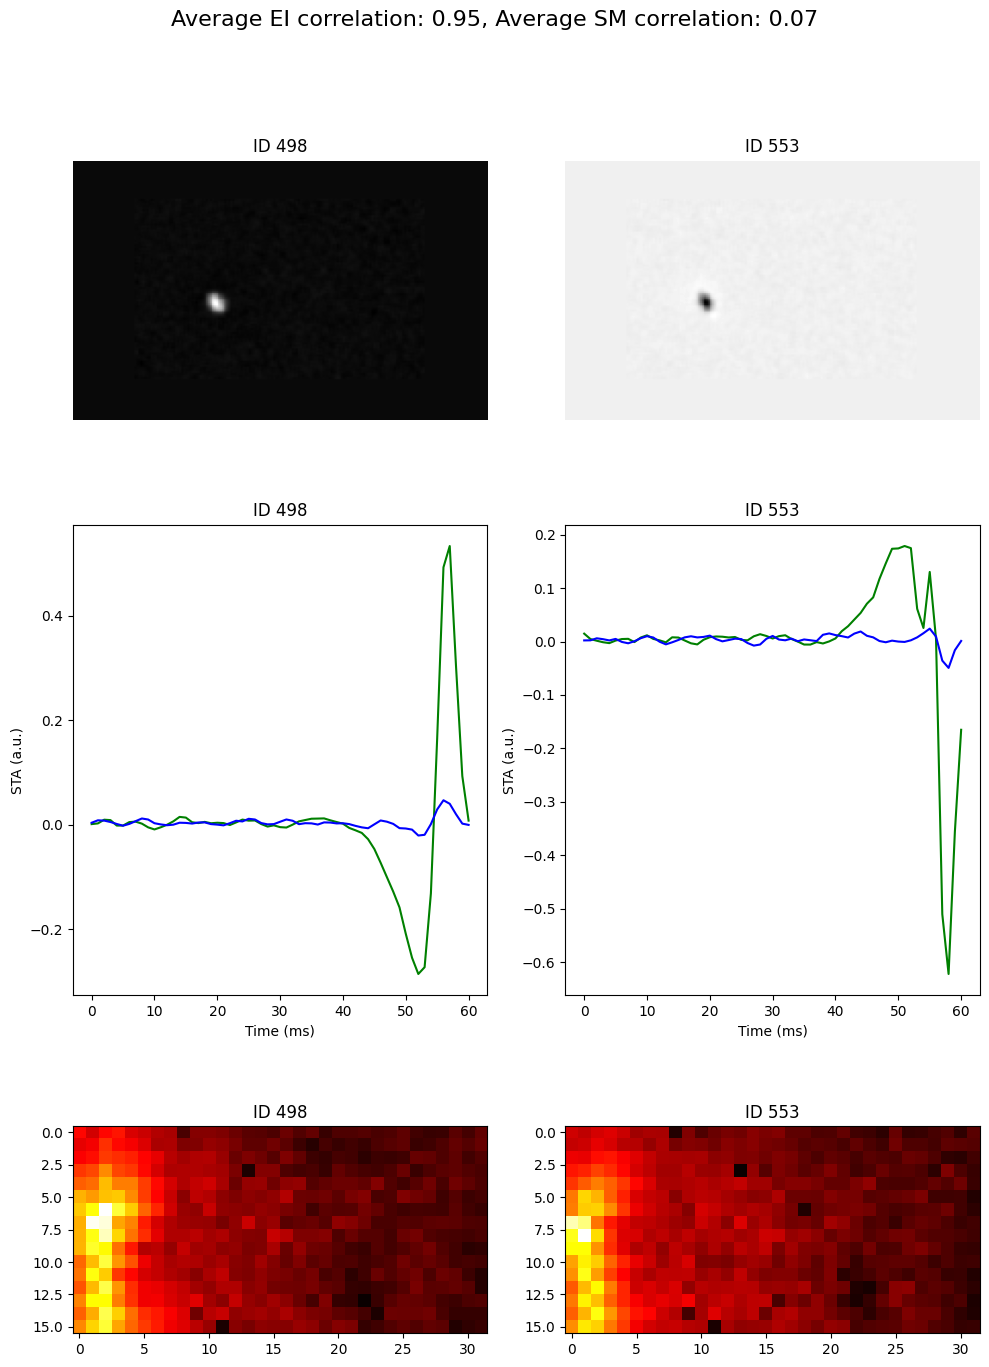

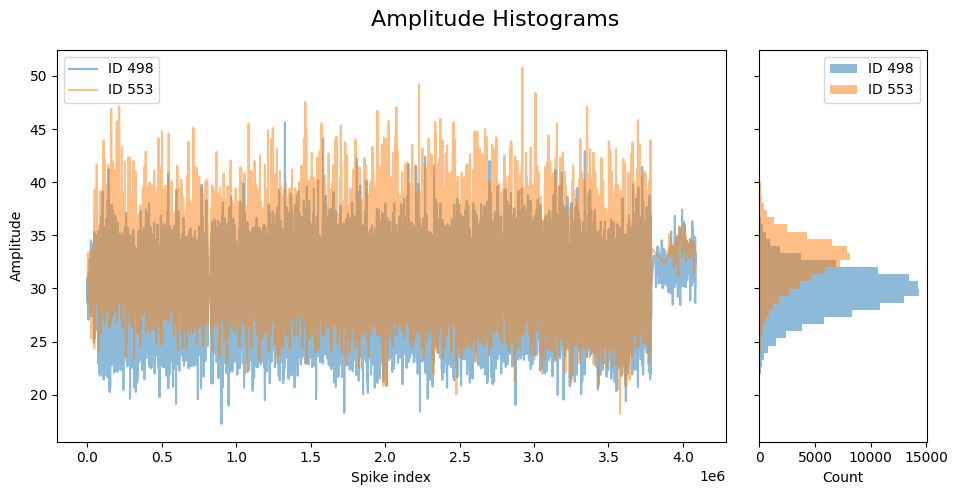

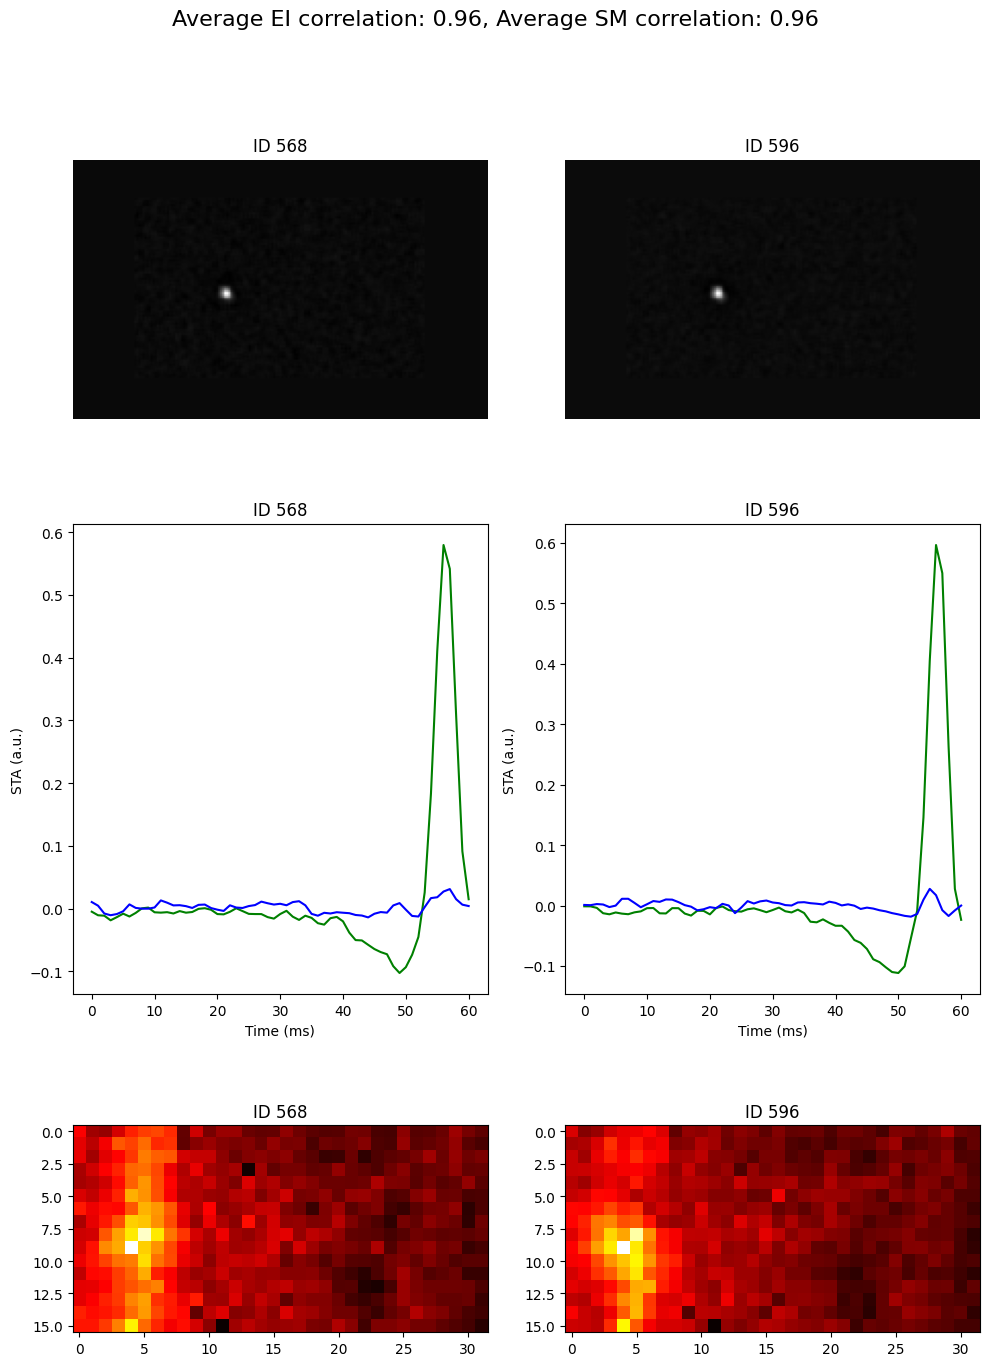

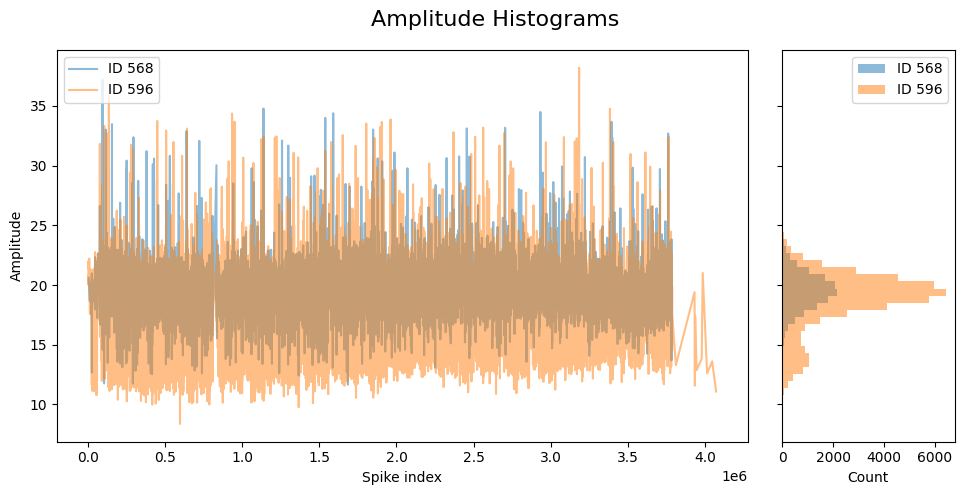

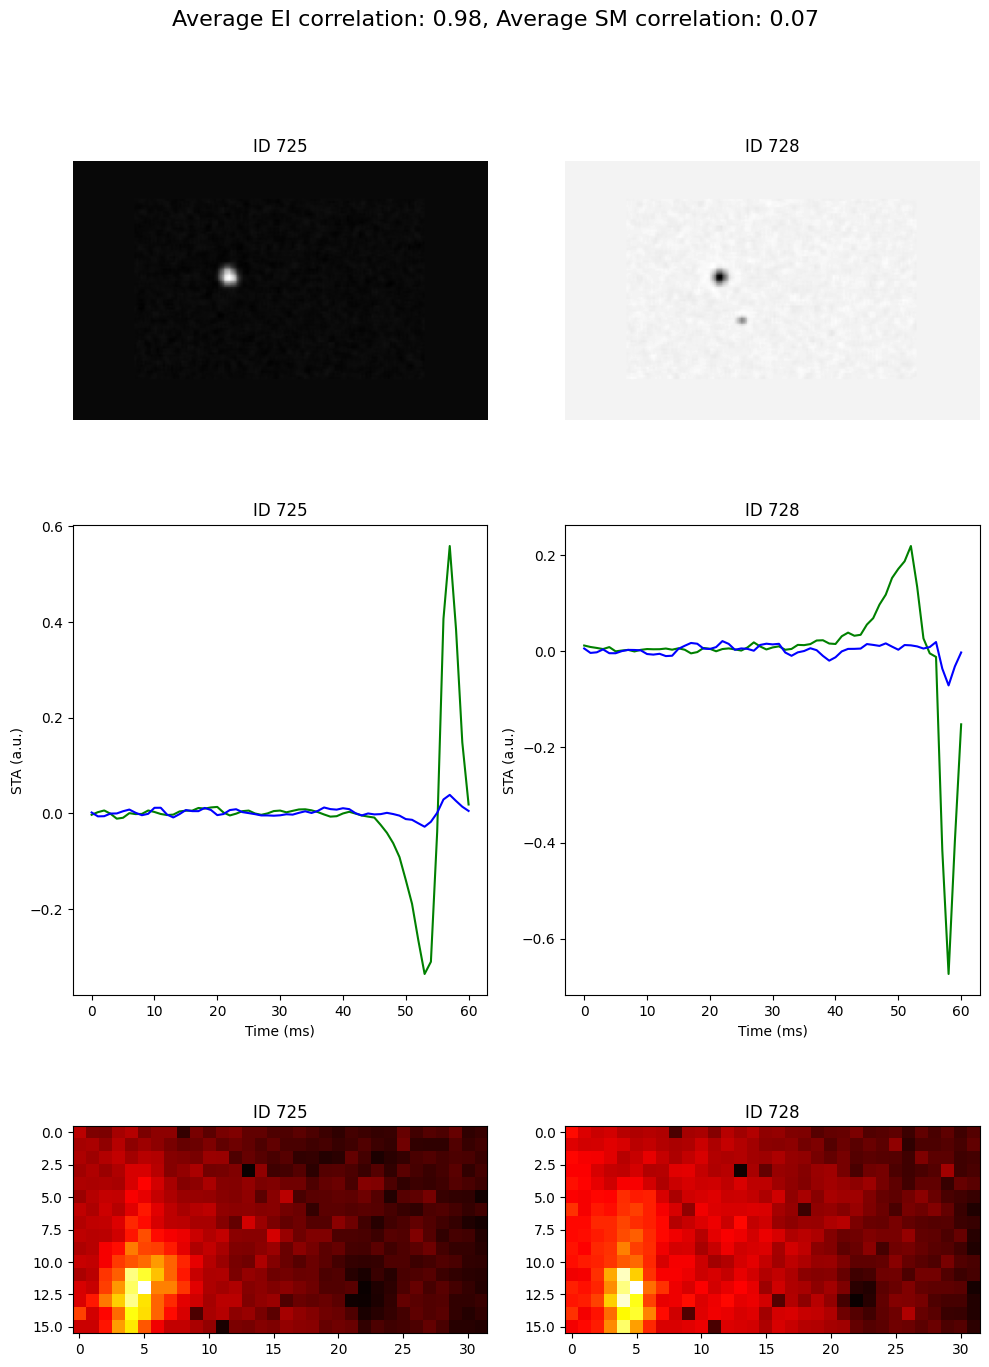

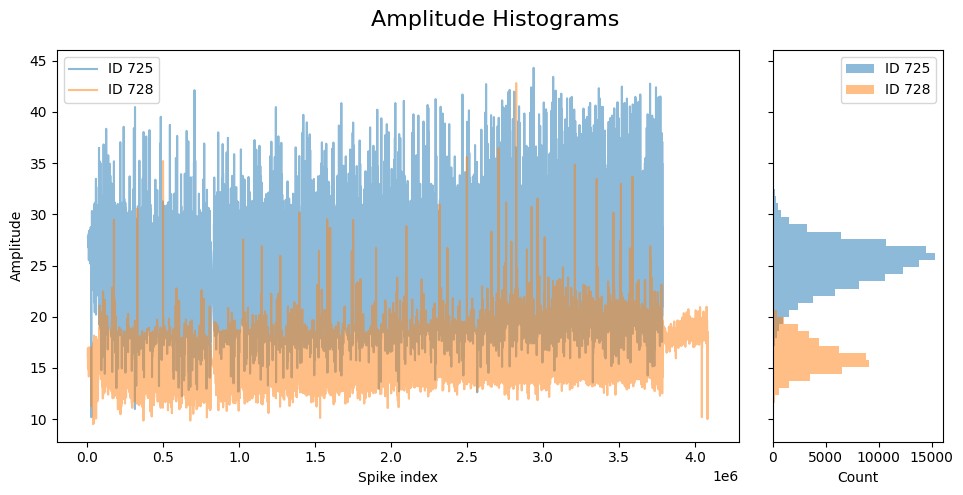

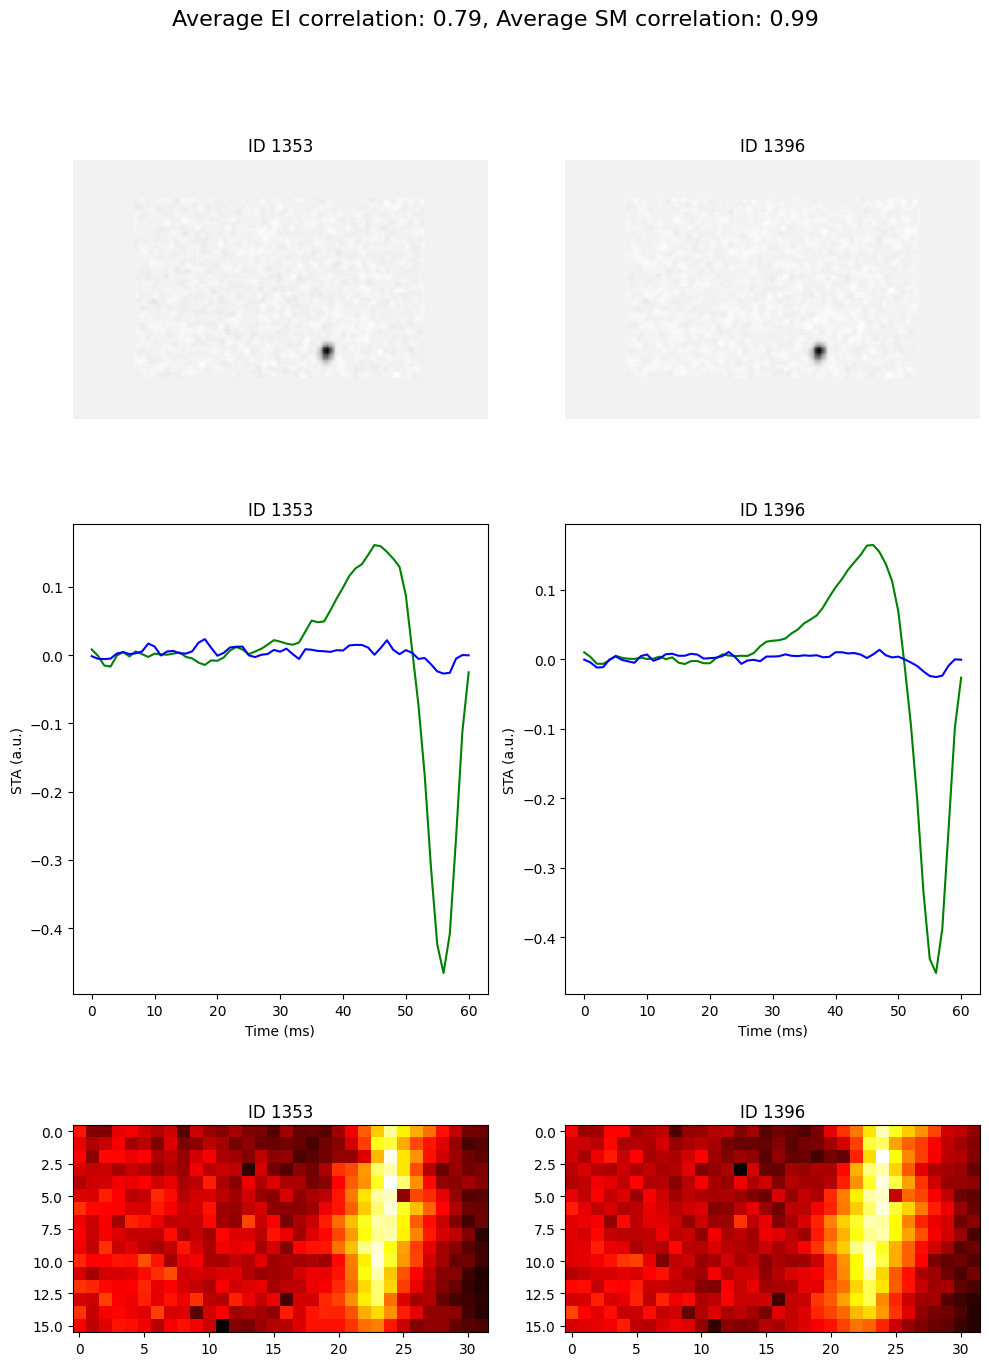

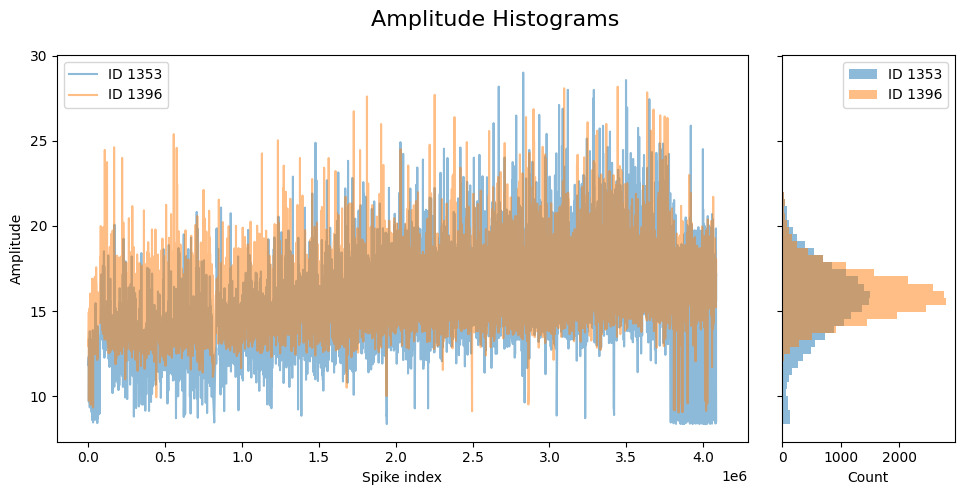

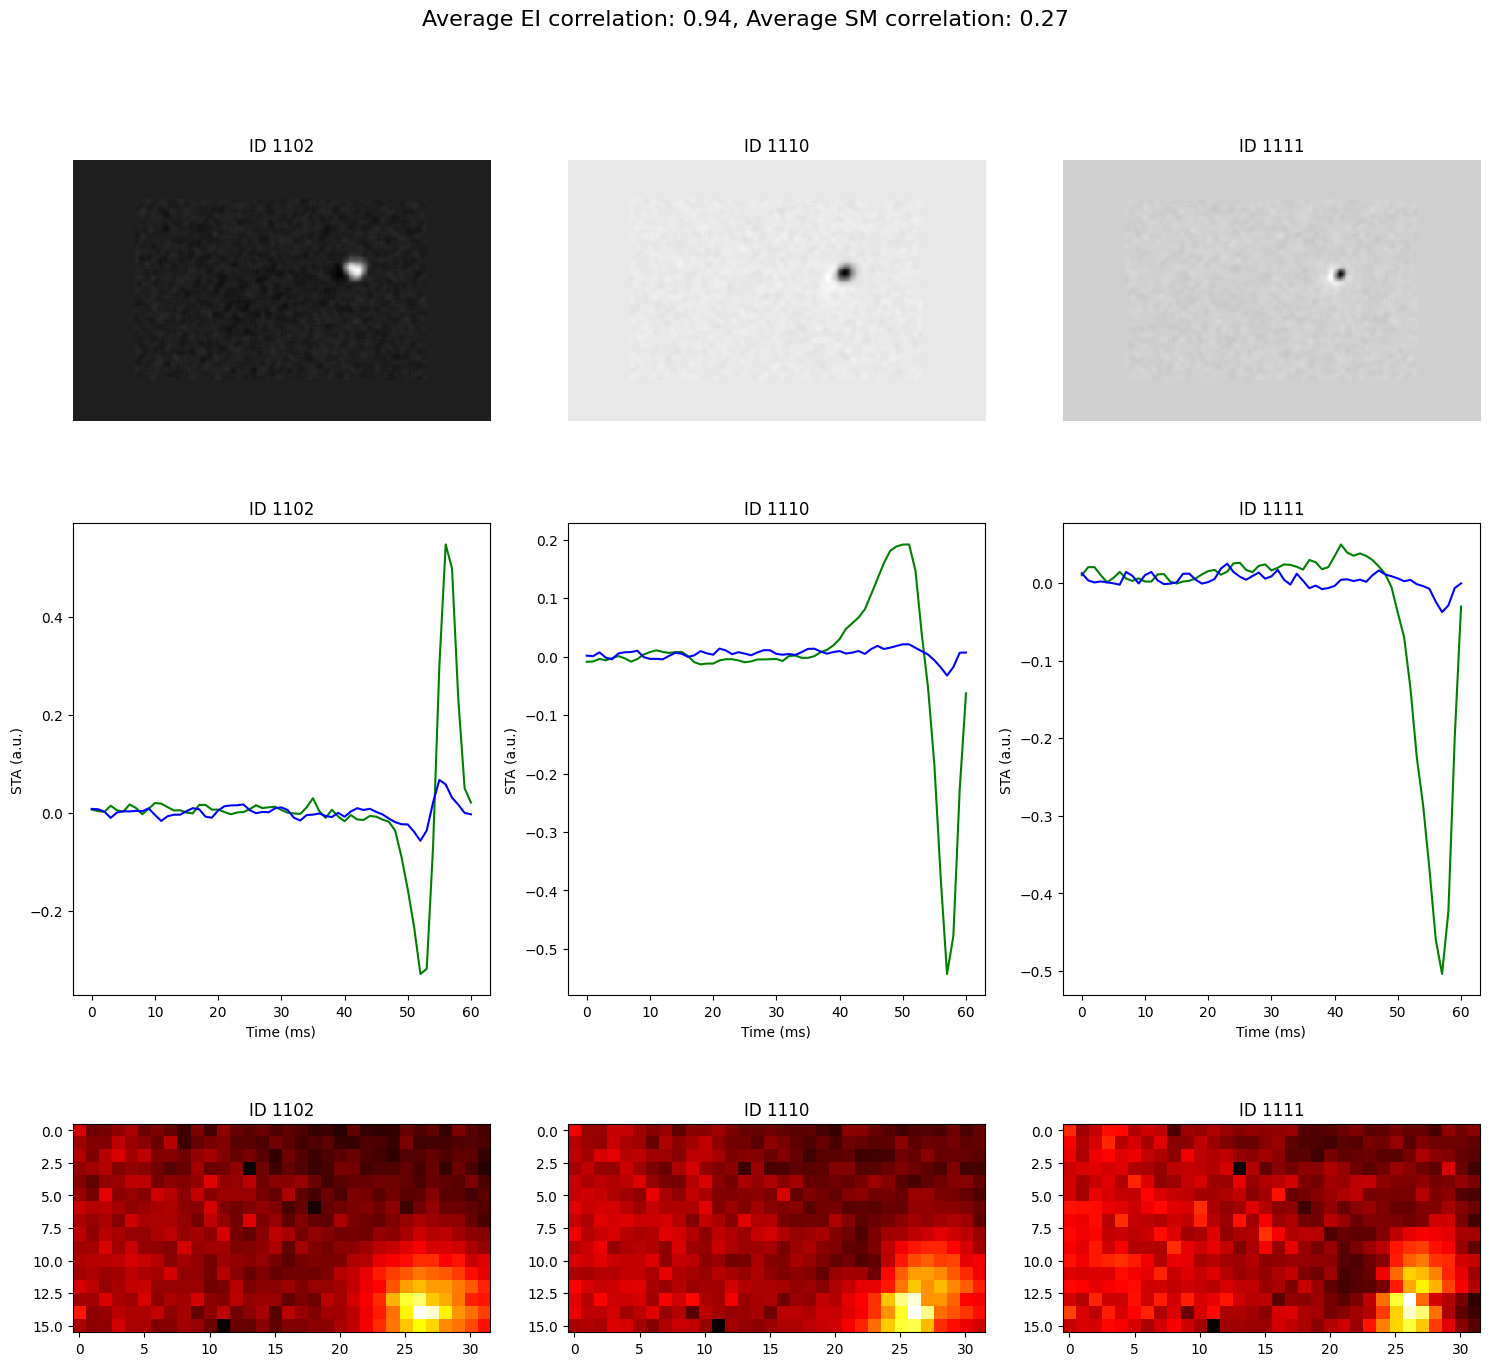

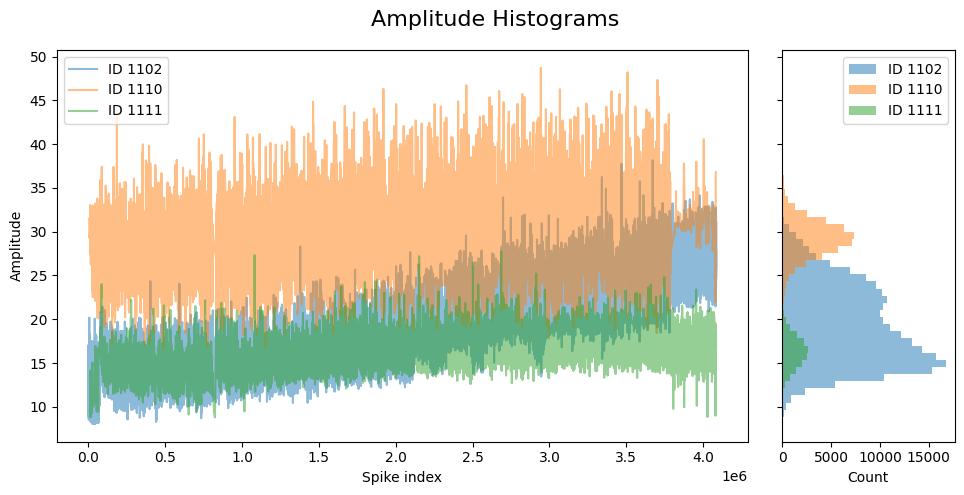

In [98]:
for pair in db.dedup_sets['extended_pairs_across']:
    db.visualize_groups(pair, axs=None);
    db.plot_amplitude_histograms(pair, axs=None);

#### 199 and 212 look awfully like the same cell. What do their top PC projections look like (from KS)?

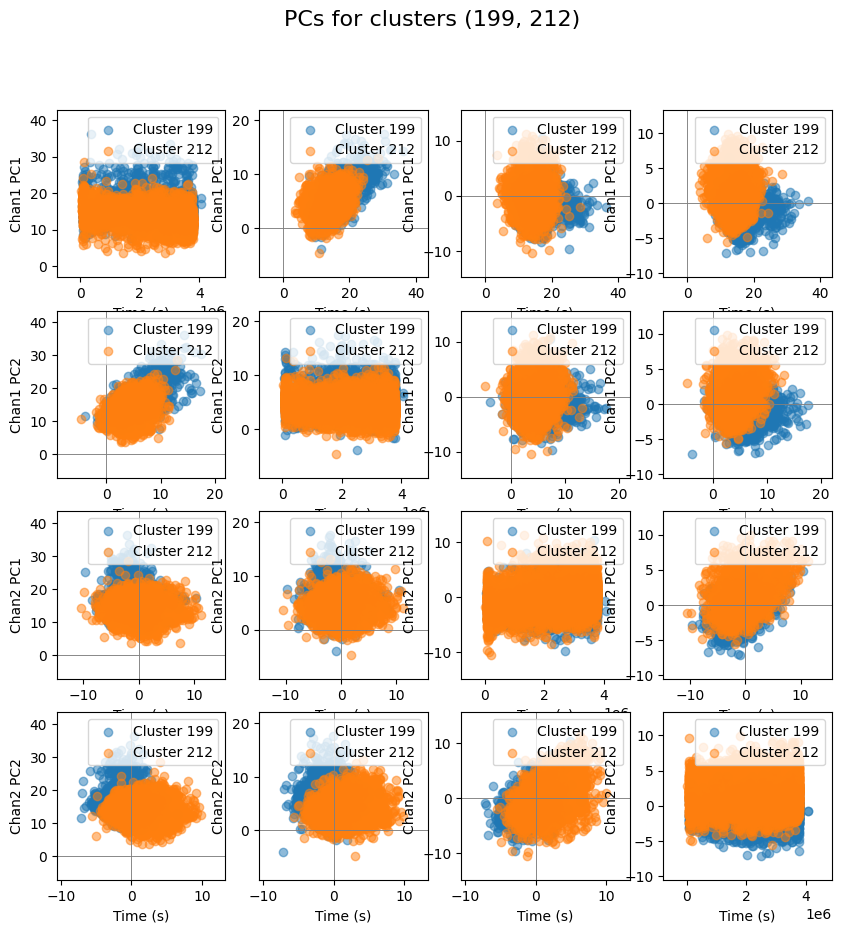

In [122]:
db.plot_pcs(pair=(199, 212));

#### not always super clear though with a 2D plot. These also have some overlap, and definitely are not the same cell.

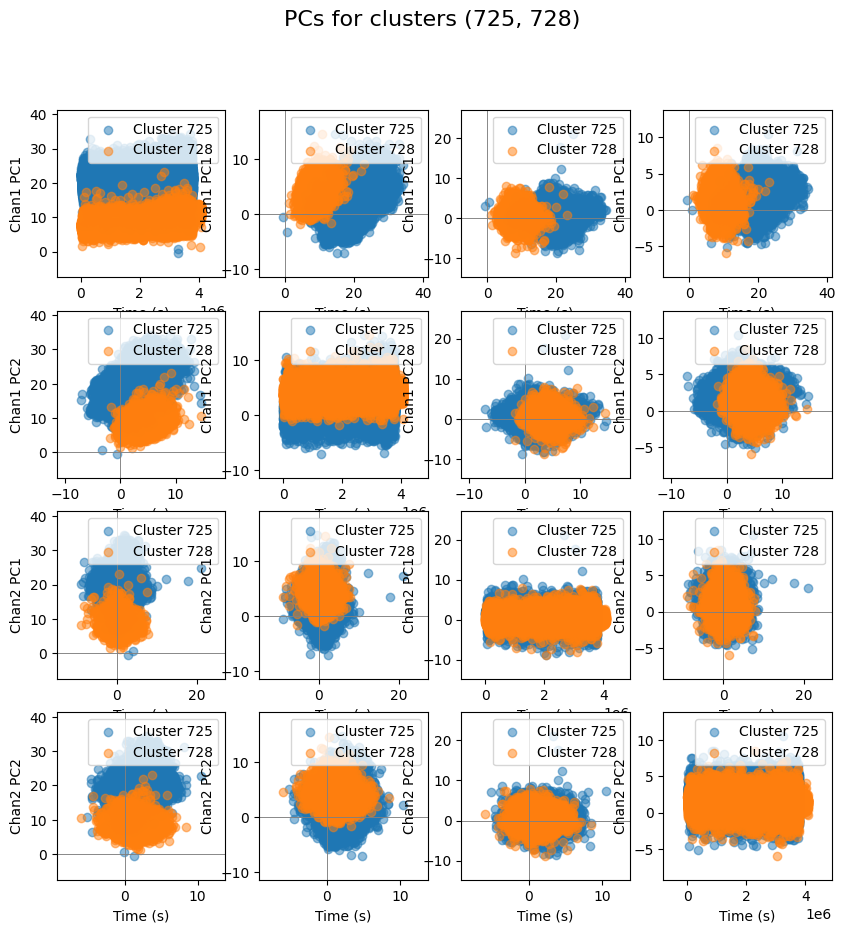

In [124]:
db.plot_pcs(pair=(725, 728));